<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/M%C3%B4_ph%E1%BB%8Fng_d%E1%BB%B1_%C4%91o%C3%A1n_l%C6%B0u_l%C6%B0%E1%BB%A3ng_giao_th%C3%B4ng_%C4%91%C3%A3_qua_s%E1%BB%ADa_%C4%91%E1%BB%95i_m%E1%BB%99t_ch%C3%BAt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phần 1: up dữ liệu và xử lý

In [1]:
import os
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Tải file
print("Vui lòng tải file tram_giao_thong.xlsx")
uploaded = files.upload()
location_file = list(uploaded.keys())[0]
print(f"File {location_file} đã được tải lên thành công.")

print("Vui lòng tải 200 file Excel (1.xlsx, 2.xlsx, ..., 200.xlsx)")
uploaded = files.upload()
print(f"Đã tải lên {len(uploaded)} file Excel.")

traffic_data_dir = 'traffic_data'
os.makedirs(traffic_data_dir, exist_ok=True)

for filename in uploaded.keys():
    if filename.endswith('.xlsx') and filename.split('.')[0].isdigit():
        with open(os.path.join(traffic_data_dir, filename), 'wb') as f:
            f.write(uploaded[filename])
num_files = len(os.listdir(traffic_data_dir))
print(f"Đã lưu {num_files} file Excel vào thư mục 'traffic_data'.")
if num_files < 190:
    print(f"Cảnh báo: Chỉ có {num_files} file Excel, mong đợi ~200 file.")

# 2. Thiết lập thư mục và hàm xử lý
output_dir = 'processed_data'
os.makedirs(output_dir, exist_ok=True)

def handle_missing_values(df, column):
    if df[column].isnull().sum() > 0:
        print(f"Phát hiện giá trị thiếu trong cột {column}. Thực hiện nội suy...")
        df[column] = df[column].interpolate(method='linear', limit_direction='both')
    return df

def normalize_flow(df, column):
    max_flow = df[column].max()
    if max_flow > 0:
        df[f'normalized_{column}'] = df[column] / max_flow
    else:
        df[f'normalized_{column}'] = df[column]
    return df, max_flow

def create_lstm_data(df, flow_column, window_size=12):
    X, y = [], []
    data = df[flow_column].values
    if len(data) < window_size + 1:
        print(f"Dữ liệu quá ngắn ({len(data)} mẫu), cần ít nhất {window_size + 1} mẫu")
        return np.array([]), np.array([])
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    X = np.array(X)[:, :, np.newaxis]
    y = np.array(y)
    return X, y

# 3. Đọc file vị trí trạm
print("Đọc file vị trí trạm...")
location_df = pd.read_excel(location_file)
location_df.columns = location_df.columns.str.lower()
expected_columns = ['id', 'latitude', 'longitude']
if not all(col in location_df.columns for col in expected_columns):
    raise ValueError("File tram_giao_thong.xlsx không có các cột: id, latitude, longitude")

if location_df['id'].duplicated().any():
    raise ValueError("Phát hiện ID trùng lặp trong file tram_giao_thong.xlsx")
if location_df[['latitude', 'longitude']].isnull().any().any():
    raise ValueError("Phát hiện giá trị thiếu trong cột latitude hoặc longitude")
if not location_df['id'].isin(range(1, 201)).all():
    raise ValueError("Cột id phải nằm trong khoảng 1-200")
print(f"Tổng số trạm: {len(location_df)}")

location_dict = location_df.set_index('id')[['latitude', 'longitude']].to_dict('index')

# 4. Đọc và xử lý file lưu lượng giao thông
all_data = []
max_flows = {}
window_size = 12
successful_stations = 0

print("Đọc và xử lý 200 file lưu lượng giao thông...")
for station_id in tqdm(range(1, 201)):
    file_path = os.path.join(traffic_data_dir, f'{station_id}.xlsx')
    if not os.path.exists(file_path):
        print(f"Không tìm thấy file {file_path}. Bỏ qua...")
        continue

    try:
        df = pd.read_excel(file_path)
        df.columns = df.columns.str.strip()
    except Exception as e:
        print(f"Lỗi đọc file {file_path}: {e}. Bỏ qua...")
        continue

    expected_columns = ['5 minutes', 'flow (veh/5 minutes)']
    if not all(col.lower() in df.columns.str.lower() for col in expected_columns):
        print(f"File {file_path} không có các cột mong đợi: {expected_columns}. Bỏ qua...")
        continue

    df = df.rename(columns={
        df.columns[df.columns.str.lower().str.contains('5 minutes')][0]: 'time',
        df.columns[df.columns.str.lower().str.contains('flow')][0]: 'flow'
    })

    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        try:
            df['time'] = pd.to_datetime(df['time'])
        except Exception as e:
            print(f"Lỗi chuyển đổi thời gian trong file {file_path}: {e}. Bỏ qua...")
            continue

    df = df[['time', 'flow']]
    df = handle_missing_values(df, 'flow')

    if (df['flow'] < 0).any():
        print(f"Phát hiện giá trị âm trong file {file_path}. Thay bằng 0...")
        df['flow'] = df['flow'].clip(lower=0)

    df, max_flow = normalize_flow(df, 'flow')
    max_flows[station_id] = max_flow

    df['id'] = station_id
    if station_id in location_dict:
        df['latitude'] = location_dict[station_id]['latitude']
        df['longitude'] = location_dict[station_id]['longitude']
    else:
        print(f"Không tìm thấy vị trí cho trạm {station_id}. Bỏ qua...")
        continue

    X, y = create_lstm_data(df, 'normalized_flow', window_size)
    if X.size == 0 or y.size == 0:
        print(f"Không tạo được dữ liệu LSTM cho trạm {station_id}. Bỏ qua...")
        continue

    if X.shape[1:] != (12, 1) or y.ndim != 1:
        print(f"Dữ liệu LSTM trạm {station_id} sai định dạng: X={X.shape}, y={y.shape}")
        continue

    np.save(os.path.join(output_dir, f'X_{station_id}.npy'), X)
    np.save(os.path.join(output_dir, f'y_{station_id}.npy'), y)
    successful_stations += 1

    all_data.append(df[['id', 'time', 'flow', 'normalized_flow', 'latitude', 'longitude']])

print(f"Xử lý thành công {successful_stations} trạm.")

if all_data:
    print("Hợp nhất dữ liệu từ tất cả trạm...")
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv(os.path.join(output_dir, 'combined_traffic_data.csv'), index=False)
else:
    print("Không có dữ liệu để hợp nhất")

if max_flows:
    max_flow_df = pd.DataFrame.from_dict(max_flows, orient='index', columns=['max_flow'])
    max_flow_df.index.name = 'id'
    max_flow_df.to_csv(os.path.join(output_dir, 'max_flows.csv'))
else:
    print("Không có giá trị max_flow để lưu")

print("Hoàn tất bước 1! Dữ liệu đã được xử lý và lưu trong thư mục 'processed_data'.")
print(f"- Số trạm xử lý thành công: {successful_stations}")
print(f"- File combined_traffic_data.csv: Dữ liệu hợp nhất từ tất cả trạm.")
print(f"- File max_flows.csv: Giá trị max_flow của mỗi trạm.")
print(f"- File X_{{id}}.npy và y_{{id}}.npy: Dữ liệu đầu vào/đầu ra cho LSTM.")

print("Tạo file zip cho thư mục processed_data...")
!zip -r processed_data.zip processed_data
print("File processed_data.zip đã sẵn sàng. Chạy 'files.download('processed_data.zip')' để tải về.")

Vui lòng tải file tram_giao_thong.xlsx


Saving tram_giao_thong.xlsx to tram_giao_thong.xlsx
File tram_giao_thong.xlsx đã được tải lên thành công.
Vui lòng tải 200 file Excel (1.xlsx, 2.xlsx, ..., 200.xlsx)


Saving 1.xlsx to 1.xlsx
Saving 2.xlsx to 2.xlsx
Saving 3.xlsx to 3.xlsx
Saving 4.xlsx to 4.xlsx
Saving 5.xlsx to 5.xlsx
Saving 6.xlsx to 6.xlsx
Saving 7.xlsx to 7.xlsx
Saving 8.xlsx to 8.xlsx
Saving 9.xlsx to 9.xlsx
Saving 10.xlsx to 10.xlsx
Saving 11.xlsx to 11.xlsx
Saving 12.xlsx to 12.xlsx
Saving 13.xlsx to 13.xlsx
Saving 14.xlsx to 14.xlsx
Saving 15.xlsx to 15.xlsx
Saving 16.xlsx to 16.xlsx
Saving 17.xlsx to 17.xlsx
Saving 18.xlsx to 18.xlsx
Saving 19.xlsx to 19.xlsx
Saving 20.xlsx to 20.xlsx
Saving 21.xlsx to 21.xlsx
Saving 22.xlsx to 22.xlsx
Saving 23.xlsx to 23.xlsx
Saving 24.xlsx to 24.xlsx
Saving 25.xlsx to 25.xlsx
Saving 26.xlsx to 26.xlsx
Saving 27.xlsx to 27.xlsx
Saving 28.xlsx to 28.xlsx
Saving 29.xlsx to 29.xlsx
Saving 30.xlsx to 30.xlsx
Saving 31.xlsx to 31.xlsx
Saving 32.xlsx to 32.xlsx
Saving 33.xlsx to 33.xlsx
Saving 34.xlsx to 34.xlsx
Saving 35.xlsx to 35.xlsx
Saving 36.xlsx to 36.xlsx
Saving 37.xlsx to 37.xlsx
Saving 38.xlsx to 38.xlsx
Saving 39.xlsx to 39.xlsx
Savi

100%|██████████| 200/200 [00:31<00:00,  6.44it/s]


Xử lý thành công 200 trạm.
Hợp nhất dữ liệu từ tất cả trạm...
Hoàn tất bước 1! Dữ liệu đã được xử lý và lưu trong thư mục 'processed_data'.
- Số trạm xử lý thành công: 200
- File combined_traffic_data.csv: Dữ liệu hợp nhất từ tất cả trạm.
- File max_flows.csv: Giá trị max_flow của mỗi trạm.
- File X_{id}.npy và y_{id}.npy: Dữ liệu đầu vào/đầu ra cho LSTM.
Tạo file zip cho thư mục processed_data...
  adding: processed_data/ (stored 0%)
  adding: processed_data/X_129.npy (deflated 95%)
  adding: processed_data/y_27.npy (deflated 85%)
  adding: processed_data/y_25.npy (deflated 85%)
  adding: processed_data/y_113.npy (deflated 77%)
  adding: processed_data/X_193.npy (deflated 95%)
  adding: processed_data/y_65.npy (deflated 73%)
  adding: processed_data/y_34.npy (deflated 87%)
  adding: processed_data/y_48.npy (deflated 75%)
  adding: processed_data/X_57.npy (deflated 95%)
  adding: processed_data/X_85.npy (deflated 95%)
  adding: processed_data/X_28.npy (deflated 95%)
  adding: processed

code thử với đông bộ hoá dữ liệu theo thời gian để chúng giống nhau

In [31]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import files

# 1. Tải file vị trí trạm
print("Vui lòng tải file tram_giao_thong.xlsx")
uploaded = files.upload()
location_file = list(uploaded.keys())[0]
location_df = pd.read_excel(location_file)
location_df.columns = location_df.columns.str.lower()
if not all(col in location_df.columns for col in ['id', 'latitude', 'longitude']):
    raise ValueError("File tram_giao_thong.xlsx phải có các cột: id, latitude, longitude")
location_dict = location_df.set_index('id')[['latitude', 'longitude']].to_dict('index')

# 2. Tải và lưu 200 file Excel lưu lượng giao thông
print("Vui lòng tải 200 file Excel (1.xlsx, 2.xlsx, ..., 200.xlsx)")
uploaded = files.upload()
traffic_data_dir = 'traffic_data'
os.makedirs(traffic_data_dir, exist_ok=True)
for filename in uploaded.keys():
    if filename.endswith('.xlsx') and filename.split('.')[0].isdigit():
        with open(os.path.join(traffic_data_dir, filename), 'wb') as f:
            f.write(uploaded[filename])

# 3. Tìm phạm vi thời gian chung
min_times = []
max_times = []
for station_id in tqdm(range(1, 201), desc="Kiểm tra phạm vi thời gian"):
    file_path = os.path.join(traffic_data_dir, f'{station_id}.xlsx')
    if os.path.exists(file_path):
        try:
            df = pd.read_excel(file_path)
            df.columns = df.columns.str.lower().str.strip()
            if '5 minutes' in df.columns:
                df['time'] = pd.to_datetime(df['5 minutes'], errors='coerce')
                if df['time'].isnull().any():
                    print(f"Giá trị thời gian không hợp lệ trong {file_path}")
                    continue
                min_times.append(df['time'].min())
                max_times.append(df['time'].max())
        except Exception as e:
            print(f"Lỗi đọc {file_path}: {e}")

if min_times and max_times:
    max_start = max(min_times)
    min_end = min(max_times)
    common_time_index = pd.date_range(start=max_start, end=min_end, freq='5T')
    print(f"Phạm vi thời gian chung: {max_start} đến {min_end}")
else:
    raise ValueError("Không tìm thấy dữ liệu thời gian hợp lệ từ các trạm")

# 4. Hàm xử lý dữ liệu
def handle_missing_values(df, column):
    if df[column].isnull().any():
        df[column] = df[column].interpolate(method='linear', limit_direction='both')
    return df

def normalize_flow(df, column):
    max_flow = df[column].max()
    if max_flow > 0:
        df[f'normalized_{column}'] = df[column] / max_flow
    else:
        df[f'normalized_{column}'] = df[column]
    return df, max_flow

def create_lstm_data(df, flow_column, window_size=12):
    X, y = [], []
    data = df[flow_column].values
    if len(data) < window_size + 1:
        return np.array([]), np.array([])
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    X = np.array(X)[:, :, np.newaxis]
    y = np.array(y)
    return X, y

# 5. Xử lý và đồng bộ dữ liệu
output_dir = 'processed_data'
os.makedirs(output_dir, exist_ok=True)
all_data = []
successful_stations = 0
window_size = 12

for station_id in tqdm(range(1, 201), desc="Xử lý và đồng bộ dữ liệu"):
    file_path = os.path.join(traffic_data_dir, f'{station_id}.xlsx')
    if not os.path.exists(file_path):
        print(f"Không tìm thấy file {file_path}")
        continue
    try:
        df = pd.read_excel(file_path)
        df.columns = df.columns.str.lower().str.strip()
        if '5 minutes' in df.columns and 'flow (veh/5 minutes)' in df.columns:
            df = df.rename(columns={'5 minutes': 'time', 'flow (veh/5 minutes)': 'flow'})
            df['time'] = pd.to_datetime(df['time'], errors='coerce')
            df['flow'] = pd.to_numeric(df['flow'], errors='coerce')
            if df['time'].isnull().any() or df['flow'].isnull().all():
                print(f"Dữ liệu không hợp lệ trong {file_path}")
                continue

            # Đồng bộ với common_time_index
            df = df.set_index('time').reindex(common_time_index).interpolate(method='linear').reset_index()
            df = df.rename(columns={'index': 'time'})
            df = handle_missing_values(df, 'flow')

            # Chuẩn hóa và tạo dữ liệu LSTM
            df, max_flow = normalize_flow(df, 'flow')
            X, y = create_lstm_data(df, 'normalized_flow', window_size)
            if X.size > 0 and y.size > 0:
                np.save(os.path.join(output_dir, f'X_{station_id}.npy'), X)
                np.save(os.path.join(output_dir, f'y_{station_id}.npy'), y)
                successful_stations += 1
                if station_id in location_dict:
                    df['latitude'] = location_dict[station_id]['latitude']
                    df['longitude'] = location_dict[station_id]['longitude']
                    all_data.append(df[['time', 'flow', 'normalized_flow', 'latitude', 'longitude']].assign(id=station_id))
    except Exception as e:
        print(f"Lỗi xử lý {file_path}: {e}")

# 6. Lưu dữ liệu hợp nhất
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv(os.path.join(output_dir, 'combined_traffic_data.csv'), index=False)
    print(f"Đã xử lý thành công {successful_stations} trạm.")
else:
    print("Không có dữ liệu để hợp nhất")

# 7. Tạo file zip
!zip -r processed_data.zip processed_data
print("Dữ liệu đã được đồng bộ và lưu. Chạy 'files.download('processed_data.zip')' để tải về.")

Vui lòng tải file tram_giao_thong.xlsx


Saving tram_giao_thong.xlsx to tram_giao_thong (1).xlsx
Vui lòng tải 200 file Excel (1.xlsx, 2.xlsx, ..., 200.xlsx)


Saving 1.xlsx to 1 (1).xlsx
Saving 2.xlsx to 2 (1).xlsx
Saving 3.xlsx to 3 (1).xlsx
Saving 4.xlsx to 4 (1).xlsx
Saving 5.xlsx to 5 (1).xlsx
Saving 6.xlsx to 6 (1).xlsx
Saving 7.xlsx to 7 (1).xlsx
Saving 8.xlsx to 8 (1).xlsx
Saving 9.xlsx to 9 (1).xlsx
Saving 10.xlsx to 10 (1).xlsx
Saving 11.xlsx to 11 (1).xlsx
Saving 12.xlsx to 12 (1).xlsx
Saving 13.xlsx to 13 (1).xlsx
Saving 14.xlsx to 14 (1).xlsx
Saving 15.xlsx to 15 (1).xlsx
Saving 16.xlsx to 16 (1).xlsx
Saving 17.xlsx to 17 (1).xlsx
Saving 18.xlsx to 18 (1).xlsx
Saving 19.xlsx to 19 (1).xlsx
Saving 20.xlsx to 20 (1).xlsx
Saving 21.xlsx to 21 (1).xlsx
Saving 22.xlsx to 22 (1).xlsx
Saving 23.xlsx to 23 (1).xlsx
Saving 24.xlsx to 24 (1).xlsx
Saving 25.xlsx to 25 (1).xlsx
Saving 26.xlsx to 26 (1).xlsx
Saving 27.xlsx to 27 (1).xlsx
Saving 28.xlsx to 28 (1).xlsx
Saving 29.xlsx to 29 (1).xlsx
Saving 30.xlsx to 30 (1).xlsx
Saving 31.xlsx to 31 (1).xlsx
Saving 32.xlsx to 32 (1).xlsx
Saving 33.xlsx to 33 (1).xlsx
Saving 34.xlsx to 34 (1).xls

Kiểm tra phạm vi thời gian: 100%|██████████| 200/200 [00:30<00:00,  6.59it/s]
<ipython-input-31-ea8d0c2c90af>:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  common_time_index = pd.date_range(start=max_start, end=min_end, freq='5T')


Phạm vi thời gian chung: 2025-03-01 00:00:00 đến 2025-02-14 00:55:00


Xử lý và đồng bộ dữ liệu: 100%|██████████| 200/200 [00:30<00:00,  6.48it/s]


Không có dữ liệu để hợp nhất
updating: processed_data/ (stored 0%)
updating: processed_data/X_129.npy (deflated 95%)
updating: processed_data/y_27.npy (deflated 85%)
updating: processed_data/y_25.npy (deflated 85%)
updating: processed_data/y_113.npy (deflated 77%)
updating: processed_data/X_193.npy (deflated 95%)
updating: processed_data/y_65.npy (deflated 73%)
updating: processed_data/y_34.npy (deflated 87%)
updating: processed_data/y_48.npy (deflated 75%)
updating: processed_data/X_57.npy (deflated 95%)
updating: processed_data/X_85.npy (deflated 95%)
updating: processed_data/X_28.npy (deflated 95%)
updating: processed_data/y_188.npy (deflated 88%)
updating: processed_data/y_140.npy (deflated 81%)
updating: processed_data/X_128.npy (deflated 96%)
updating: processed_data/y_116.npy (deflated 85%)
updating: processed_data/y_98.npy (deflated 85%)
updating: processed_data/X_170.npy (deflated 96%)
updating: processed_data/y_187.npy (deflated 85%)
updating: processed_data/y_21.npy (deflate

phần 2 vẽ các nút dựa trên toạ độ

Sử dụng file vị trí trạm: tram_giao_thong.xlsx
Đọc file vị trí trạm...
Tổng số trạm: 200
Tạo đồ thị với các nút và dữ liệu cục bộ...


100%|██████████| 200/200 [00:00<00:00, 475.91it/s]


Đồ thị có 200 nút.
Tính khoảng cách Haversine và thêm cạnh...
Đồ thị có 42 cạnh (ngưỡng 0.5 km).
Vẽ đồ thị giao thông...
Hình ảnh đồ thị đã được lưu vào traffic_network/traffic_graph.png


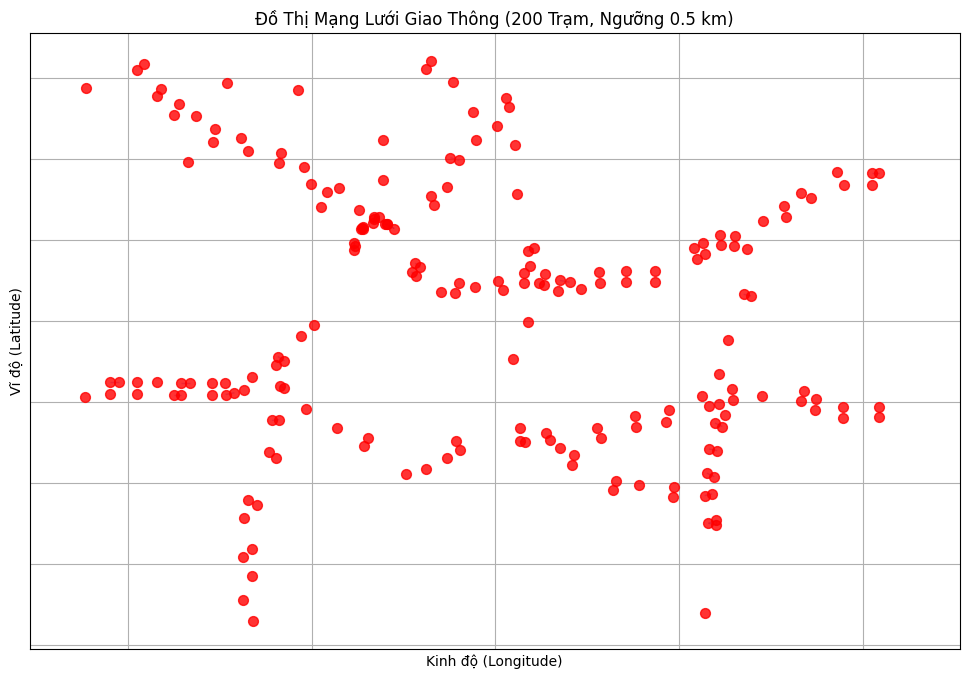

Đồ thị (không có X_k, y_k) đã được lưu vào traffic_network/traffic_graph.gml
Đồ thị (bao gồm X_k, y_k) đã được lưu vào traffic_network/traffic_graph.pkl
Ma trận khoảng cách đã được lưu vào traffic_network/distance_matrix.csv
Tạo file zip cho thư mục traffic_network...
  adding: traffic_network/ (stored 0%)
  adding: traffic_network/traffic_graph.gml (deflated 87%)
  adding: traffic_network/traffic_graph.pkl (deflated 95%)
  adding: traffic_network/traffic_graph.png (deflated 15%)
  adding: traffic_network/distance_matrix.csv (deflated 54%)
File traffic_network.zip đã sẵn sàng. Chạy 'files.download('traffic_network.zip')' để tải về.


In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from google.colab import files
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

def haversine_distance(lat1, lon1, lat2, lon2):
    R_e = 6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R_e * c

location_file = None
for fname in os.listdir('.'):
    if fname.startswith('tram_giao_thong') and fname.endswith('.xlsx'):
        location_file = fname
        break

if location_file is None:
    print("Không tìm thấy file tram_giao_thong.xlsx. Vui lòng tải file.")
    uploaded = files.upload()
    location_file = list(uploaded.keys())[0]
print(f"Sử dụng file vị trí trạm: {location_file}")

processed_data_dir = 'processed_data'
if not os.path.exists(processed_data_dir):
    print("Không tìm thấy thư mục processed_data. Vui lòng tải processed_data.zip và giải nén.")
    uploaded = files.upload()
    zip_file = list(uploaded.keys())[0]
    !unzip {zip_file}
    print(f"Đã giải nén {zip_file}.")

print("Đọc file vị trí trạm...")
location_df = pd.read_excel(location_file)
location_df.columns = location_df.columns.str.lower()

expected_columns = ['id', 'latitude', 'longitude']
missing_cols = [col for col in expected_columns if col not in location_df.columns]
if missing_cols:
    raise ValueError(f"File tram_giao_thong.xlsx thiếu các cột: {missing_cols}")

if location_df['id'].duplicated().any():
    raise ValueError("Phát hiện ID trùng lặp trong file tram_giao_thong.xlsx")
if location_df[['latitude', 'longitude']].isnull().any().any():
    raise ValueError("Phát hiện giá trị thiếu trong cột latitude hoặc longitude")
if not location_df['id'].isin(range(1, 201)).all():
    raise ValueError("Cột id phải nằm trong khoảng 1-200")
print(f"Tổng số trạm: {len(location_df)}")

G = nx.Graph()
print("Tạo đồ thị với các nút và dữ liệu cục bộ...")
for _, row in tqdm(location_df.iterrows(), total=len(location_df)):
    station_id = int(row['id'])
    lat = row['latitude']
    lon = row['longitude']

    x_file = os.path.join(processed_data_dir, f'X_{station_id}.npy')
    y_file = os.path.join(processed_data_dir, f'y_{station_id}.npy')

    if not (os.path.exists(x_file) and os.path.exists(y_file)):
        print(f"Thiếu file X_{station_id}.npy hoặc y_{station_id}.npy. Bỏ qua trạm {station_id}...")
        continue

    X_k = np.load(x_file)
    y_k = np.load(y_file)

    if X_k.ndim == 2 and X_k.shape[1] == 12:
        print(f"Reshaping X_{station_id}: {X_k.shape} -> {X_k.shape[0], 12, 1}")
        X_k = X_k[:, :, np.newaxis]

    if X_k.ndim != 3 or X_k.shape[1] != 12 or y_k.ndim != 1 or X_k.shape[0] != y_k.shape[0]:
        print(f"Dữ liệu trạm {station_id} sai định dạng: X={X_k.shape}, y={y_k.shape}. Bỏ qua...")
        continue

    G.add_node(station_id, latitude=lat, longitude=lon, X_k=X_k, y_k=y_k)

print(f"Đồ thị có {G.number_of_nodes()} nút.")
if G.number_of_nodes() < 190:
    print(f"Cảnh báo: Đồ thị chỉ có {G.number_of_nodes()} nút, mong đợi ~200.")

print("Tính khoảng cách Haversine và thêm cạnh...")
distance_matrix = pd.DataFrame(index=location_df['id'], columns=location_df['id'])
distance_threshold = 0.5

for i, row_i in location_df.iterrows():
    id_i = int(row_i['id'])
    lat_i = row_i['latitude']
    lon_i = row_i['longitude']

    for j, row_j in location_df.iterrows():
        id_j = int(row_j['id'])
        if id_i >= id_j:
            continue

        lat_j = row_j['latitude']
        lon_j = row_j['longitude']
        distance = haversine_distance(lat_i, lon_i, lat_j, lon_j)

        distance_matrix.loc[id_i, id_j] = distance
        distance_matrix.loc[id_j, id_i] = distance

        if distance < distance_threshold:
            G.add_edge(id_i, id_j, weight=distance)

print(f"Đồ thị có {G.number_of_edges()} cạnh (ngưỡng {distance_threshold} km).")

print("Vẽ đồ thị giao thông...")
plt.figure(figsize=(12, 8))
pos = {node: (G.nodes[node]['longitude'], G.nodes[node]['latitude']) for node in G.nodes()}
nx.draw_networkx_nodes(G, pos, node_color='red', node_size=50, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.3)
plt.title(f"Đồ Thị Mạng Lưới Giao Thông ({G.number_of_nodes()} Trạm, Ngưỡng {distance_threshold} km)")
plt.xlabel("Kinh độ (Longitude)")
plt.ylabel("Vĩ độ (Latitude)")
plt.grid(True)

output_dir = 'traffic_network'
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, 'traffic_graph.png')
plt.savefig(plot_file, format='png', dpi=300, bbox_inches='tight')
print(f"Hình ảnh đồ thị đã được lưu vào {plot_file}")
plt.show()

G_copy = G.copy()
for node in G_copy.nodes():
    if 'X_k' in G_copy.nodes[node]:
        del G_copy.nodes[node]['X_k']
    if 'y_k' in G_copy.nodes[node]:
        del G_copy.nodes[node]['y_k']

graph_file = os.path.join(output_dir, 'traffic_graph.gml')
nx.write_gml(G_copy, graph_file)
print(f"Đồ thị (không có X_k, y_k) đã được lưu vào {graph_file}")

pickle_file = os.path.join(output_dir, 'traffic_graph.pkl')
with open(pickle_file, 'wb') as f:
    pickle.dump(G, f)
print(f"Đồ thị (bao gồm X_k, y_k) đã được lưu vào {pickle_file}")

distance_file = os.path.join(output_dir, 'distance_matrix.csv')
distance_matrix.to_csv(distance_file)
print(f"Ma trận khoảng cách đã được lưu vào {distance_file}")

print("Tạo file zip cho thư mục traffic_network...")
!zip -r traffic_network.zip traffic_network
print("File traffic_network.zip đã sẵn sàng. Chạy 'files.download('traffic_network.zip')' để tải về.")

phần 3: phâm cụm dbscan

Sử dụng file vị trí trạm: tram_giao_thong.xlsx
Đọc file vị trí trạm...
Tổng số trạm: 200
Tính ma trận khoảng cách Haversine...
Phân cụm với DBSCAN (eps=0.5 km, min_samples=3)...
Số cụm tìm được: 5
Số trạm nhiễu: 182
Gộp các điểm nhiễu vào cụm gần nhất...

Thông tin nút Fog:
   cluster_id   latitude   longitude  num_stations
0           0  33.824267 -117.979600            55
1           1  34.012990 -118.166000            15
2           2  34.009867 -118.158800            61
3           3  33.996247 -118.176374            48
4           4  34.007800 -118.172700            21
Vẽ kết quả phân cụm...
Hình ảnh phân cụm đã được lưu vào traffic_clusters/traffic_clusters.png


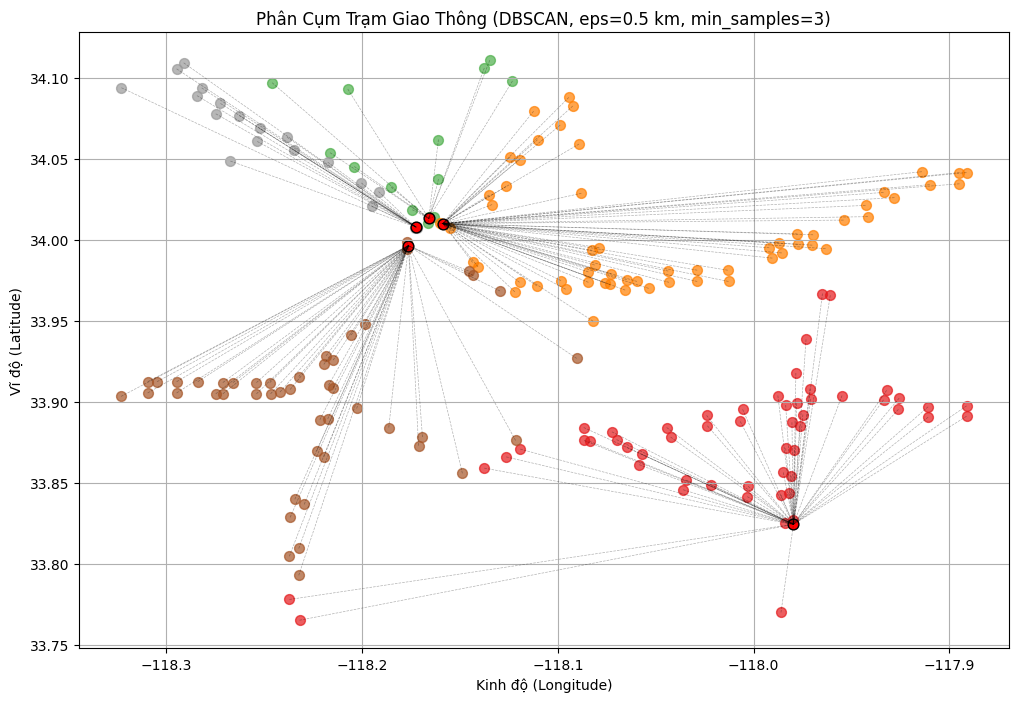

Thông tin cụm đã được lưu vào traffic_clusters/station_clusters.csv
Tọa độ nút Fog đã được lưu vào traffic_clusters/fog_nodes.csv
Tạo file zip cho thư mục traffic_clusters...
updating: traffic_clusters/ (stored 0%)
updating: traffic_clusters/station_clusters.csv (deflated 74%)
updating: traffic_clusters/traffic_clusters.png (deflated 8%)
updating: traffic_clusters/fog_nodes.csv (deflated 83%)
File traffic_clusters.zip đã sẵn sàng. Chạy 'files.download('traffic_clusters.zip')' để tải về.


In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from google.colab import files
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def haversine_distance(coords1, coords2):
    R_e = 6371
    lat1, lon1 = coords1
    lat2, lon2 = coords2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R_e * c

def haversine_matrix(coords):
    n = len(coords)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = haversine_distance(coords[i], coords[j])
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

location_file = None
for fname in os.listdir('.'):
    if fname.startswith('tram_giao_thong') and fname.endswith('.xlsx'):
        location_file = fname
        break

if location_file is None:
    print("Không tìm thấy file tram_giao_thong.xlsx. Vui lòng tải file.")
    uploaded = files.upload()
    location_file = list(uploaded.keys())[0]
print(f"Sử dụng file vị trí trạm: {location_file}")

print("Đọc file vị trí trạm...")
location_df = pd.read_excel(location_file)
location_df.columns = location_df.columns.str.lower()

expected_columns = ['id', 'latitude', 'longitude']
missing_cols = [col for col in expected_columns if col not in location_df.columns]
if missing_cols:
    raise ValueError(f"File tram_giao_thong.xlsx thiếu các cột: {missing_cols}")

if location_df['id'].duplicated().any():
    raise ValueError("Phát hiện ID trùng lặp trong file tram_giao_thong.xlsx")
if location_df[['latitude', 'longitude']].isnull().any().any():
    raise ValueError("Phát hiện giá trị thiếu trong cột latitude hoặc longitude")
if not location_df['id'].isin(range(1, 201)).all():
    raise ValueError("Cột id phải nằm trong khoảng 1-200")
print(f"Tổng số trạm: {len(location_df)}")

coords = location_df[['latitude', 'longitude']].values
print("Tính ma trận khoảng cách Haversine...")
distance_matrix = haversine_matrix(coords)

eps = 0.5
min_samples = 3
print(f"Phân cụm với DBSCAN (eps={eps} km, min_samples={min_samples})...")
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(distance_matrix)

location_df['cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Số cụm tìm được: {n_clusters}")
print(f"Số trạm nhiễu: {(labels == -1).sum()}")

fog_nodes = []
for cluster_id in range(n_clusters):
    cluster_data = location_df[location_df['cluster'] == cluster_id]
    if len(cluster_data) == 0:
        continue
    lat_center = cluster_data['latitude'].mean()
    lon_center = cluster_data['longitude'].mean()
    center = (lat_center, lon_center)
    min_distance = float('inf')
    nearest_station = None
    for _, station in cluster_data.iterrows():
        dist = haversine_distance((station['latitude'], station['longitude']), center)
        if dist < min_distance:
            min_distance = dist
            nearest_station = station
    fog_nodes.append({
        'cluster_id': cluster_id,
        'latitude': nearest_station['latitude'],
        'longitude': nearest_station['longitude'],
        'num_stations': len(cluster_data),
        'station_ids': cluster_data['id'].tolist()
    })

fog_df = pd.DataFrame(fog_nodes)
if (labels == -1).sum() > 0:
    print("Gộp các điểm nhiễu vào cụm gần nhất...")
    noise_points = location_df[location_df['cluster'] == -1]
    for index, noise_point in noise_points.iterrows():
        min_distance = float('inf')
        nearest_cluster = None
        for cluster_id in range(n_clusters):
            cluster_center = fog_df[fog_df['cluster_id'] == cluster_id][['latitude', 'longitude']].values[0]
            distance = haversine_distance((noise_point['latitude'], noise_point['longitude']), cluster_center)
            if distance < min_distance:
                min_distance = distance
                nearest_cluster = cluster_id
        location_df.at[index, 'cluster'] = nearest_cluster
        fog_df.loc[fog_df['cluster_id'] == nearest_cluster, 'station_ids'].iloc[0].append(noise_point['id'])
        fog_df.loc[fog_df['cluster_id'] == nearest_cluster, 'num_stations'] += 1

print("\nThông tin nút Fog:")
print(fog_df[['cluster_id', 'latitude', 'longitude', 'num_stations']])

print("Vẽ kết quả phân cụm...")
plt.figure(figsize=(12, 8))
unique_labels = set(location_df['cluster'])
colors = ListedColormap(plt.cm.Set1(np.linspace(0, 1, len(unique_labels))))
for label, color in zip(unique_labels, colors.colors):
    cluster_data = location_df[location_df['cluster'] == label]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'],
                c=[color], s=50, alpha=0.7)
for _, station in location_df.iterrows():
    cluster_id = station['cluster']
    if cluster_id != -1:
        fog_coords = fog_df[fog_df['cluster_id'] == cluster_id][['longitude', 'latitude']].values[0]
        plt.plot([station['longitude'], fog_coords[0]],
                 [station['latitude'], fog_coords[1]],
                 color='black', linestyle='--', linewidth=0.5, alpha=0.3)
plt.scatter(fog_df['longitude'], fog_df['latitude'], c='red', marker='o', s=60,
            edgecolors='black')
plt.title(f"Phân Cụm Trạm Giao Thông (DBSCAN, eps={eps} km, min_samples={min_samples})")
plt.xlabel("Kinh độ (Longitude)")
plt.ylabel("Vĩ độ (Latitude)")
plt.grid(True)

output_dir = 'traffic_clusters'
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, 'traffic_clusters.png')
plt.savefig(plot_file, format='png', dpi=300, bbox_inches='tight')
print(f"Hình ảnh phân cụm đã được lưu vào {plot_file}")
plt.show()

clusters_file = os.path.join(output_dir, 'station_clusters.csv')
location_df.to_csv(clusters_file, index=False)
print(f"Thông tin cụm đã được lưu vào {clusters_file}")

fog_file = os.path.join(output_dir, 'fog_nodes.csv')
fog_df.to_csv(fog_file, index=False)
print(f"Tọa độ nút Fog đã được lưu vào {fog_file}")

print("Tạo file zip cho thư mục traffic_clusters...")
!zip -r traffic_clusters.zip traffic_clusters
print("File traffic_clusters.zip đã sẵn sàng. Chạy 'files.download('traffic_clusters.zip')' để tải về.")

HBDBSCAN cải tiến lại dbscan

Sử dụng file vị trí trạm: tram_giao_thong.xlsx
Đọc file vị trí trạm...
Tổng số trạm: 200
Tính ma trận khoảng cách Haversine...
Phân cụm với HDBSCAN...
Số cụm tìm được: 29
Số trạm nhiễu: 32
Gộp các điểm nhiễu vào cụm gần nhất...

Thông tin nút Fog:
    cluster_id   latitude   longitude  num_stations
0            0  33.792800 -118.232400             5
1            1  33.836533 -118.229600             5
2            2  33.896800 -117.910800             8
3            3  33.865867 -118.126400             5
4            4  33.876533 -118.070000            11
5            5  33.887733 -118.006800             4
6            6  33.824267 -117.979600             4
7            7  33.878133 -118.169200             3
8            8  33.851467 -118.034400             3
9            9  33.898933 -117.978000            11
10          10  33.856267 -117.984800             8
11          11  34.041333 -117.894800             5
12          12  33.978933 -118.072800            25
13          13  33.98053

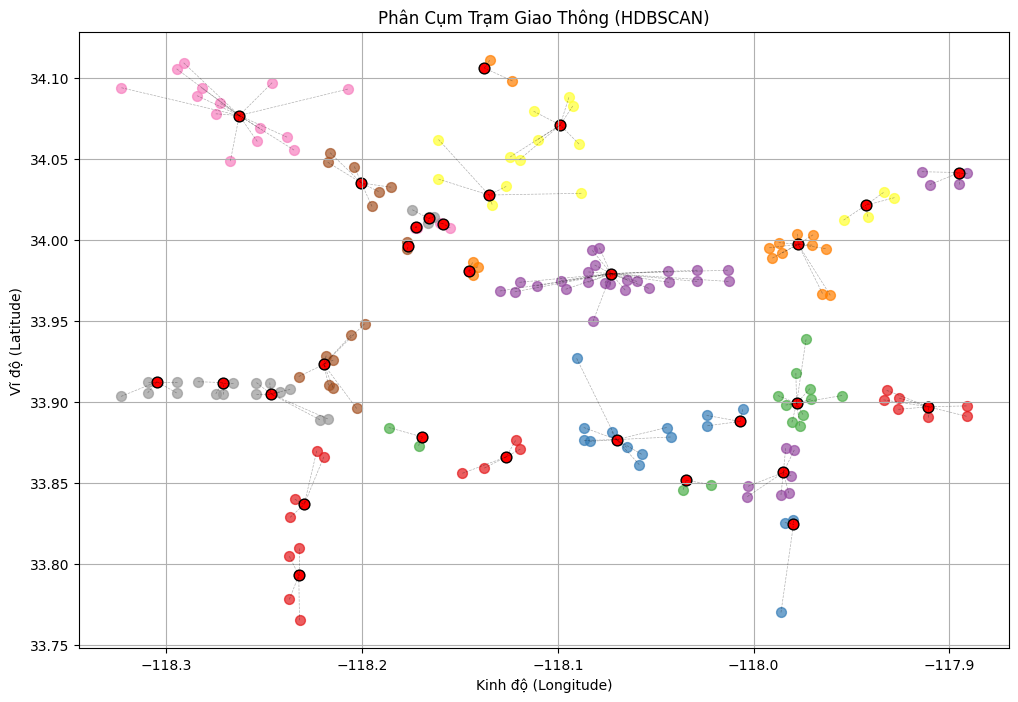

Thông tin cụm đã được lưu vào traffic_clusters/station_clusters.csv
Tọa độ nút Fog đã được lưu vào traffic_clusters/fog_nodes.csv
Tạo file zip cho thư mục traffic_clusters...
updating: traffic_clusters/ (stored 0%)
updating: traffic_clusters/station_clusters.csv (deflated 74%)
updating: traffic_clusters/traffic_clusters.png (deflated 10%)
updating: traffic_clusters/fog_nodes.csv (deflated 65%)
File traffic_clusters.zip đã sẵn sàng. Chạy 'files.download('traffic_clusters.zip')' để tải về.


In [14]:
import os
import pandas as pd
import numpy as np
import hdbscan  # Thay vì DBSCAN
from google.colab import files
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Hàm tính khoảng cách Haversine
def haversine_distance(coords1, coords2):
    R_e = 6371  # Bán kính Trái Đất (km)
    lat1, lon1 = coords1
    lat2, lon2 = coords2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R_e * c

# Tính ma trận khoảng cách Haversine
def haversine_matrix(coords):
    n = len(coords)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = haversine_distance(coords[i], coords[j])
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

# Kiểm tra và tải file tram_giao_thong.xlsx
location_file = None
for fname in os.listdir('.'):
    if fname.startswith('tram_giao_thong') and fname.endswith('.xlsx'):
        location_file = fname
        break

if location_file is None:
    print("Không tìm thấy file tram_giao_thong.xlsx. Vui lòng tải file.")
    uploaded = files.upload()
    location_file = list(uploaded.keys())[0]
print(f"Sử dụng file vị trí trạm: {location_file}")

# Đọc file vị trí trạm
print("Đọc file vị trí trạm...")
location_df = pd.read_excel(location_file)
location_df.columns = location_df.columns.str.lower()

# Kiểm tra các cột bắt buộc
expected_columns = ['id', 'latitude', 'longitude']
missing_cols = [col for col in expected_columns if col not in location_df.columns]
if missing_cols:
    raise ValueError(f"File tram_giao_thong.xlsx thiếu các cột: {missing_cols}")

# Kiểm tra dữ liệu
if location_df['id'].duplicated().any():
    raise ValueError("Phát hiện ID trùng lặp trong file tram_giao_thong.xlsx")
if location_df[['latitude', 'longitude']].isnull().any().any():
    raise ValueError("Phát hiện giá trị thiếu trong cột latitude hoặc longitude")
if not location_df['id'].isin(range(1, 201)).all():
    raise ValueError("Cột id phải nằm trong khoảng 1-200")
print(f"Tổng số trạm: {len(location_df)}")

# Lấy tọa độ
coords = location_df[['latitude', 'longitude']].values

# Tính ma trận khoảng cách Haversine
print("Tính ma trận khoảng cách Haversine...")
distance_matrix = haversine_matrix(coords)

# Phân cụm với HDBSCAN
print("Phân cụm với HDBSCAN...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=2, metric='precomputed')
labels = clusterer.fit_predict(distance_matrix)

# Gán nhãn cụm vào DataFrame
location_df['cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Số cụm tìm được: {n_clusters}")
print(f"Số trạm nhiễu: {(labels == -1).sum()}")

# Tính toán nút Fog cho mỗi cụm
fog_nodes = []
for cluster_id in range(n_clusters):
    cluster_data = location_df[location_df['cluster'] == cluster_id]
    if len(cluster_data) == 0:
        continue
    lat_center = cluster_data['latitude'].mean()
    lon_center = cluster_data['longitude'].mean()
    center = (lat_center, lon_center)
    min_distance = float('inf')
    nearest_station = None
    for _, station in cluster_data.iterrows():
        dist = haversine_distance((station['latitude'], station['longitude']), center)
        if dist < min_distance:
            min_distance = dist
            nearest_station = station
    fog_nodes.append({
        'cluster_id': cluster_id,
        'latitude': nearest_station['latitude'],
        'longitude': nearest_station['longitude'],
        'num_stations': len(cluster_data),
        'station_ids': cluster_data['id'].tolist()
    })

fog_df = pd.DataFrame(fog_nodes)

# Gán các điểm nhiễu vào cụm gần nhất
if (labels == -1).sum() > 0:
    print("Gộp các điểm nhiễu vào cụm gần nhất...")
    noise_points = location_df[location_df['cluster'] == -1]
    for index, noise_point in noise_points.iterrows():
        min_distance = float('inf')
        nearest_cluster = None
        for cluster_id in range(n_clusters):
            cluster_center = fog_df[fog_df['cluster_id'] == cluster_id][['latitude', 'longitude']].values[0]
            distance = haversine_distance((noise_point['latitude'], noise_point['longitude']), cluster_center)
            if distance < min_distance:
                min_distance = distance
                nearest_cluster = cluster_id
        location_df.at[index, 'cluster'] = nearest_cluster
        fog_df.loc[fog_df['cluster_id'] == nearest_cluster, 'station_ids'].iloc[0].append(noise_point['id'])
        fog_df.loc[fog_df['cluster_id'] == nearest_cluster, 'num_stations'] += 1

print("\nThông tin nút Fog:")
print(fog_df[['cluster_id', 'latitude', 'longitude', 'num_stations']])

# Vẽ kết quả phân cụm
print("Vẽ kết quả phân cụm...")
plt.figure(figsize=(12, 8))
unique_labels = set(location_df['cluster'])
colors = ListedColormap(plt.cm.Set1(np.linspace(0, 1, len(unique_labels))))
for label, color in zip(unique_labels, colors.colors):
    cluster_data = location_df[location_df['cluster'] == label]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'],
                c=[color], s=50, alpha=0.7)
for _, station in location_df.iterrows():
    cluster_id = station['cluster']
    if cluster_id != -1:
        fog_coords = fog_df[fog_df['cluster_id'] == cluster_id][['longitude', 'latitude']].values[0]
        plt.plot([station['longitude'], fog_coords[0]],
                 [station['latitude'], fog_coords[1]],
                 color='black', linestyle='--', linewidth=0.5, alpha=0.3)
plt.scatter(fog_df['longitude'], fog_df['latitude'], c='red', marker='o', s=60,
            edgecolors='black')
plt.title("Phân Cụm Trạm Giao Thông (HDBSCAN)")
plt.xlabel("Kinh độ (Longitude)")
plt.ylabel("Vĩ độ (Latitude)")
plt.grid(True)

# Lưu hình ảnh
output_dir = 'traffic_clusters'
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, 'traffic_clusters.png')
plt.savefig(plot_file, format='png', dpi=300, bbox_inches='tight')
print(f"Hình ảnh phân cụm đã được lưu vào {plot_file}")
plt.show()

# Lưu thông tin cụm và nút Fog
clusters_file = os.path.join(output_dir, 'station_clusters.csv')
location_df.to_csv(clusters_file, index=False)
print(f"Thông tin cụm đã được lưu vào {clusters_file}")

fog_file = os.path.join(output_dir, 'fog_nodes.csv')
fog_df.to_csv(fog_file, index=False)
print(f"Tọa độ nút Fog đã được lưu vào {fog_file}")

# Tạo file zip
print("Tạo file zip cho thư mục traffic_clusters...")
!zip -r traffic_clusters.zip traffic_clusters
print("File traffic_clusters.zip đã sẵn sàng. Chạy 'files.download('traffic_clusters.zip')' để tải về.")

phần 4 hình thành liên minh

Phần 4: Hình thành liên minh cho các nút Fog bằng K-Means...
Phân cụm với K-Means (n_clusters=10)...
Kiểm tra khoảng cách đến tâm cụm (< 10 km)...
Đã lưu thông tin lân cận vào traffic_alliances/neighbors.txt
Đã lưu thông tin liên minh vào traffic_alliances/aggregators.txt
Vẽ đồ thị liên minh Fog...
Hình ảnh đồ thị liên minh đã được lưu vào traffic_alliances/alliance_graph.png


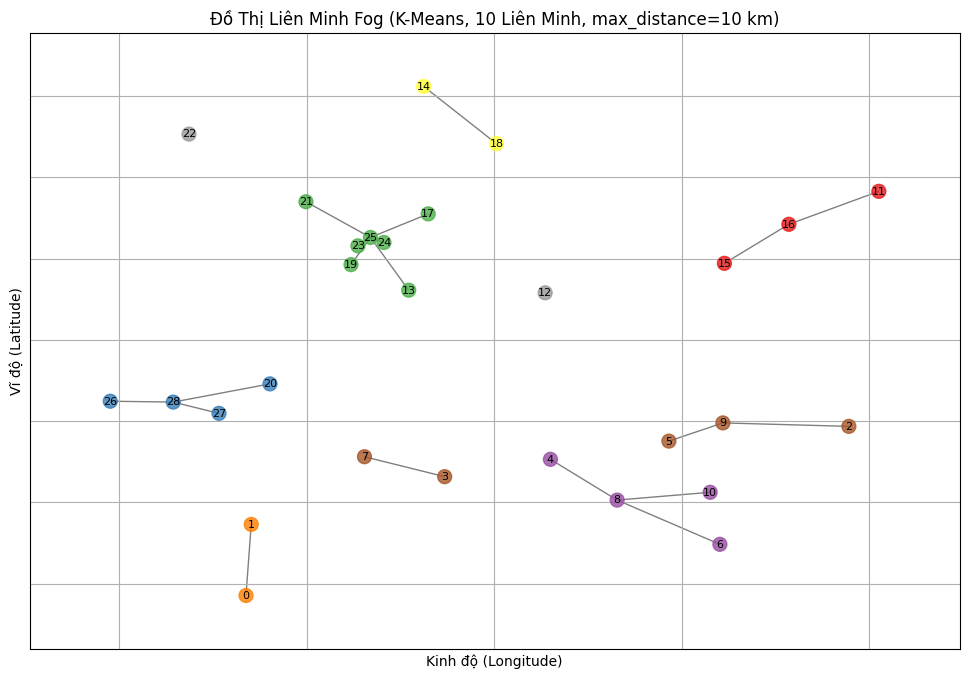

Tạo file zip cho thư mục traffic_alliances...
updating: traffic_alliances/ (stored 0%)
updating: traffic_alliances/aggregators.txt (deflated 81%)
updating: traffic_alliances/alliance_graph.png (deflated 16%)
updating: traffic_alliances/neighbors.txt (deflated 76%)
File traffic_alliances.zip đã sẵn sàng. Chạy 'files.download('traffic_alliances.zip')' để tải về.


In [19]:
import os
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Hàm tính khoảng cách Haversine (km)
def haversine_distance(lat1, lon1, lat2, lon2):
    R_e = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R_e * c

def form_fog_alliances(fog_df, max_distance=5, n_clusters=None):
    """
    Hình thành liên minh cho các nút Fog bằng K-Means, đảm bảo khoảng cách đến tâm cụm < max_distance (km).
    Vẽ đồ thị thể hiện các liên minh kết nối.
    """
    print("Phần 4: Hình thành liên minh cho các nút Fog bằng K-Means...")

    # Kiểm tra tính hợp lệ của fog_df
    required_columns = ['cluster_id', 'latitude', 'longitude', 'num_stations', 'station_ids']
    missing_cols = [col for col in required_columns if col not in fog_df.columns]
    if missing_cols:
        raise ValueError(f"fog_df thiếu các cột cần thiết: {missing_cols}")
    if fog_df.empty:
        raise ValueError("fog_df rỗng, không thể hình thành liên minh")
    if fog_df['cluster_id'].duplicated().any():
        raise ValueError("Phát hiện cluster_id trùng lặp trong fog_df")

    # Chuẩn bị tọa độ cho K-Means
    coords = fog_df[['latitude', 'longitude']].values

    # Chuẩn hóa tọa độ để K-Means hiệu quả hơn
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    # Ước lượng số cụm nếu không được chỉ định
    if n_clusters is None:
        n_clusters = max(1, len(fog_df) // 2)  # Mặc định: 1 cụm cho mỗi 2 Fog
        print(f"Không chỉ định n_clusters, sử dụng n_clusters={n_clusters}")

    # Phân cụm bằng K-Means
    print(f"Phân cụm với K-Means (n_clusters={n_clusters})...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    fog_df['alliance_id'] = kmeans.fit_predict(coords_scaled)
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Tâm cụm gốc

    # Kiểm tra khoảng cách đến tâm cụm
    print(f"Kiểm tra khoảng cách đến tâm cụm (< {max_distance} km)...")
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]
        center_lat, center_lon = cluster_centers[alliance_id]
        for _, fog in cluster_fogs.iterrows():
            dist = haversine_distance(fog['latitude'], fog['longitude'], center_lat, center_lon)
            if dist > max_distance:
                print(f"Cảnh báo: Fog {fog['cluster_id']} trong liên minh {alliance_id} "
                      f"có khoảng cách đến tâm cụm {dist:.2f} km > {max_distance} km")

    # Chọn aggregator: Fog gần tâm cụm nhất
    aggregators = {}
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]
        if cluster_fogs.empty:
            continue
        center_lat, center_lon = cluster_centers[alliance_id]
        min_dist = float('inf')
        aggregator_id = None
        for _, fog in cluster_fogs.iterrows():
            dist = haversine_distance(fog['latitude'], fog['longitude'], center_lat, center_lon)
            if dist < min_dist:
                min_dist = dist
                aggregator_id = fog['cluster_id']
        for _, fog in cluster_fogs.iterrows():
            aggregators[fog['cluster_id']] = aggregator_id

    # Xây dựng danh sách lân cận (các Fog trong cùng liên minh)
    neighbors = {row['cluster_id']: [] for _, row in fog_df.iterrows()}
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]['cluster_id'].tolist()
        for fog_id in cluster_fogs:
            neighbors[fog_id] = [other_id for other_id in cluster_fogs if other_id != fog_id]

    # Lưu kết quả
    output_dir = 'traffic_alliances'
    os.makedirs(output_dir, exist_ok=True)

    # Lưu thông tin lân cận
    with open(os.path.join(output_dir, 'neighbors.txt'), 'w') as f:
        for fog_id, neighbor_list in neighbors.items():
            f.write(f"Fog {fog_id}: Neighbors {neighbor_list}\n")
    print(f"Đã lưu thông tin lân cận vào {os.path.join(output_dir, 'neighbors.txt')}")

    # Lưu thông tin aggregator
    with open(os.path.join(output_dir, 'aggregators.txt'), 'w') as f:
        for fog_id, agg_id in aggregators.items():
            f.write(f"Fog {fog_id}: Aggregator {agg_id}\n")
    print(f"Đã lưu thông tin liên minh vào {os.path.join(output_dir, 'aggregators.txt')}")

    # Vẽ đồ thị liên minh
    print("Vẽ đồ thị liên minh Fog...")
    G = nx.Graph()

    # Thêm các nút Fog
    for _, row in fog_df.iterrows():
        fog_id = row['cluster_id']
        G.add_node(fog_id, latitude=row['latitude'], longitude=row['longitude'], alliance_id=row['alliance_id'])

    # Thêm cạnh giữa các Fog trong cùng liên minh
    for alliance_id in range(n_clusters):
        alliance_fogs = fog_df[fog_df['alliance_id'] == alliance_id]['cluster_id'].tolist()
        aggregator_id = aggregators.get(alliance_fogs[0], alliance_fogs[0]) if alliance_fogs else None
        for fog_id in alliance_fogs:
            if fog_id != aggregator_id:
                G.add_edge(fog_id, aggregator_id)

    # Tạo vị trí cho các nút
    pos = {fog_id: (data['longitude'], data['latitude']) for fog_id, data in G.nodes(data=True)}

    # Tô màu theo liên minh
    unique_alliances = sorted(fog_df['alliance_id'].unique())
    colors = ListedColormap(plt.cm.Set1(np.linspace(0, 1, len(unique_alliances))))
    node_colors = [colors(unique_alliances.index(data['alliance_id'])) for _, data in G.nodes(data=True)]

    # Vẽ đồ thị
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Thiết lập tiêu đề và trục
    plt.title(f"Đồ Thị Liên Minh Fog (K-Means, {len(unique_alliances)} Liên Minh, max_distance={max_distance} km)")
    plt.xlabel("Kinh độ (Longitude)")
    plt.ylabel("Vĩ độ (Latitude)")
    plt.grid(True)

    # Lưu hình ảnh
    plot_file = os.path.join(output_dir, 'alliance_graph.png')
    plt.savefig(plot_file, format='png', dpi=300, bbox_inches='tight')
    print(f"Hình ảnh đồ thị liên minh đã được lưu vào {plot_file}")

    # Hiển thị đồ thị
    plt.show()

    # Tạo file zip
    print("Tạo file zip cho thư mục traffic_alliances...")
    !zip -r traffic_alliances.zip traffic_alliances
    print("File traffic_alliances.zip đã sẵn sàng. Chạy 'files.download('traffic_alliances.zip')' để tải về.")

    return aggregators

# Chạy nếu là script chính
if __name__ == "__main__":
    fog_df = pd.read_csv('traffic_clusters/fog_nodes.csv')
    form_fog_alliances(fog_df, max_distance=10, n_clusters=10)  # n_clusters mặc định là 10

phần 4 cải tiến

Phần 4: Hình thành liên minh cho các nút Fog dựa trên khoảng cách Haversine...
Phân cụm với phương pháp dựa trên khoảng cách (n_clusters=3)...
Phát hiện 1 nút Fog không thuộc liên minh nào, gán vào liên minh gần nhất...
Kiểm tra khoảng cách đến tâm liên minh (< 15 km)...
Cảnh báo: Fog 11 trong liên minh 0 có khoảng cách đến tâm liên minh 15.13 km > 15 km
Liên minh 0: Nút tổng hợp (aggregator) là Fog 9 (khoảng cách đến tâm: 2.47 km)
Liên minh 1: Nút tổng hợp (aggregator) là Fog 7 (khoảng cách đến tâm: 3.56 km)
Liên minh 2: Nút tổng hợp (aggregator) là Fog 25 (khoảng cách đến tâm: 1.81 km)
Đã lưu thông tin lân cận vào traffic_alliances/neighbors.txt
Đã lưu thông tin liên minh vào traffic_alliances/aggregators.txt
Vẽ đồ thị liên minh Fog...
Hình ảnh đồ thị liên minh đã được lưu vào traffic_alliances/alliance_graph.png


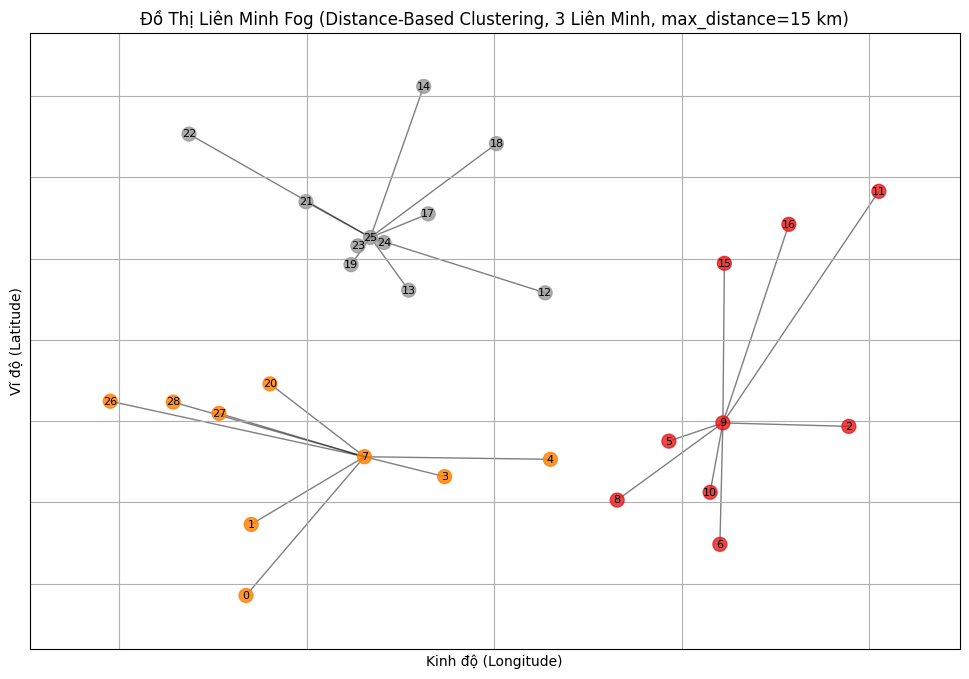

Tạo file zip cho thư mục traffic_alliances...
updating: traffic_alliances/aggregators.txt (deflated 83%)
updating: traffic_alliances/alliance_graph.png (deflated 15%)
updating: traffic_alliances/neighbors.txt (deflated 83%)
updating: traffic_alliances/ (stored 0%)
File traffic_alliances.zip đã sẵn sàng. Chạy 'files.download('traffic_alliances.zip')' để tải về.


In [29]:
import os
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Hàm tính khoảng cách Haversine (km)
def haversine_distance(lat1, lon1, lat2, lon2):
    R_e = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R_e * c

def form_fog_alliances(fog_df, max_distance=5, n_clusters=None):
    """
    Hình thành liên minh cho các nút Fog dựa trên khoảng cách Haversine.
    Đảm bảo tất cả các nút Fog thuộc một liên minh, gán các nút cô lập vào liên minh gần nhất.
    Nút gần tâm liên minh nhất sẽ được chọn làm nút tổng hợp (aggregator).
    Vẽ đồ thị thể hiện các liên minh kết nối.
    """
    print("Phần 4: Hình thành liên minh cho các nút Fog dựa trên khoảng cách Haversine...")

    # Kiểm tra tính hợp lệ của fog_df
    required_columns = ['cluster_id', 'latitude', 'longitude', 'num_stations', 'station_ids']
    missing_cols = [col for col in required_columns if col not in fog_df.columns]
    if missing_cols:
        raise ValueError(f"fog_df thiếu các cột cần thiết: {missing_cols}")
    if fog_df.empty:
        raise ValueError("fog_df rỗng, không thể hình thành liên minh")
    if fog_df['cluster_id'].duplicated().any():
        raise ValueError("Phát hiện cluster_id trùng lặp trong fog_df")

    # Chuẩn bị tọa độ
    coords = fog_df[['latitude', 'longitude']].values

    # Ước lượng số cụm nếu không được chỉ định
    if n_clusters is None:
        n_clusters = max(1, len(fog_df) // 2)  # Mặc định: 1 cụm cho mỗi 2 Fog
        print(f"Không chỉ định n_clusters, sử dụng n_clusters={n_clusters}")

    # Phân cụm dựa trên khoảng cách
    print(f"Phân cụm với phương pháp dựa trên khoảng cách (n_clusters={n_clusters})...")

    # Chọn ngẫu nhiên các trung tâm ban đầu
    np.random.seed(0)  # Đảm bảo kết quả có thể tái lập
    center_indices = np.random.choice(len(fog_df), n_clusters, replace=False)
    centers = coords[center_indices]

    # Gán các nút Fog vào liên minh dựa trên khoảng cách
    labels = np.full(len(fog_df), -1, dtype=int)  # Ban đầu tất cả đều chưa được gán
    for i in range(len(fog_df)):
        distances = [haversine_distance(coords[i][0], coords[i][1], center[0], center[1])
                     for center in centers]
        min_dist = min(distances)
        if min_dist <= max_distance:  # Chỉ gán nếu khoảng cách nhỏ hơn max_distance
            labels[i] = np.argmin(distances)

    # Gán các nút cô lập (nhãn -1) vào liên minh gần nhất
    isolated_nodes = fog_df[labels == -1]
    if len(isolated_nodes) > 0:
        print(f"Phát hiện {len(isolated_nodes)} nút Fog không thuộc liên minh nào, gán vào liên minh gần nhất...")
        isolated_indices = np.where(labels == -1)[0]
        for idx in isolated_indices:
            distances = [haversine_distance(coords[idx][0], coords[idx][1], center[0], center[1])
                         for center in centers]
            labels[idx] = np.argmin(distances)

    fog_df['alliance_id'] = labels

    # Tính tâm liên minh thực tế (trung bình tọa độ của các nút trong liên minh)
    cluster_centers = np.zeros((n_clusters, 2))
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]
        if not cluster_fogs.empty:
            cluster_centers[alliance_id] = [cluster_fogs['latitude'].mean(), cluster_fogs['longitude'].mean()]
        else:
            cluster_centers[alliance_id] = centers[alliance_id]  # Giữ nguyên trung tâm ban đầu nếu liên minh rỗng

    # Kiểm tra khoảng cách đến tâm liên minh
    print(f"Kiểm tra khoảng cách đến tâm liên minh (< {max_distance} km)...")
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]
        if cluster_fogs.empty:
            continue
        center_lat, center_lon = cluster_centers[alliance_id]
        for _, fog in cluster_fogs.iterrows():
            dist = haversine_distance(fog['latitude'], fog['longitude'], center_lat, center_lon)
            if dist > max_distance:
                print(f"Cảnh báo: Fog {fog['cluster_id']} trong liên minh {alliance_id} "
                      f"có khoảng cách đến tâm liên minh {dist:.2f} km > {max_distance} km")

    # Chọn aggregator: Nút Fog gần tâm liên minh nhất
    aggregators = {}
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]
        if cluster_fogs.empty:
            continue
        center_lat, center_lon = cluster_centers[alliance_id]
        min_dist = float('inf')
        aggregator_id = None
        for _, fog in cluster_fogs.iterrows():
            dist = haversine_distance(fog['latitude'], fog['longitude'], center_lat, center_lon)
            if dist < min_dist:
                min_dist = dist
                aggregator_id = fog['cluster_id']
        for _, fog in cluster_fogs.iterrows():
            aggregators[fog['cluster_id']] = aggregator_id
        print(f"Liên minh {alliance_id}: Nút tổng hợp (aggregator) là Fog {aggregator_id} "
              f"(khoảng cách đến tâm: {min_dist:.2f} km)")

    # Xây dựng danh sách lân cận (các Fog trong cùng liên minh)
    neighbors = {row['cluster_id']: [] for _, row in fog_df.iterrows()}
    for alliance_id in range(n_clusters):
        cluster_fogs = fog_df[fog_df['alliance_id'] == alliance_id]['cluster_id'].tolist()
        for fog_id in cluster_fogs:
            neighbors[fog_id] = [other_id for other_id in cluster_fogs if other_id != fog_id]

    # Lưu kết quả
    output_dir = 'traffic_alliances'
    os.makedirs(output_dir, exist_ok=True)

    # Lưu thông tin lân cận
    with open(os.path.join(output_dir, 'neighbors.txt'), 'w') as f:
        for fog_id, neighbor_list in neighbors.items():
            f.write(f"Fog {fog_id}: Neighbors {neighbor_list}\n")
    print(f"Đã lưu thông tin lân cận vào {os.path.join(output_dir, 'neighbors.txt')}")

    # Lưu thông tin aggregator
    with open(os.path.join(output_dir, 'aggregators.txt'), 'w') as f:
        for fog_id, agg_id in aggregators.items():
            f.write(f"Fog {fog_id}: Aggregator {agg_id}\n")
    print(f"Đã lưu thông tin liên minh vào {os.path.join(output_dir, 'aggregators.txt')}")

    # Vẽ đồ thị liên minh
    print("Vẽ đồ thị liên minh Fog...")
    G = nx.Graph()

    # Thêm các nút Fog
    for _, row in fog_df.iterrows():
        fog_id = row['cluster_id']
        G.add_node(fog_id, latitude=row['latitude'], longitude=row['longitude'], alliance_id=row['alliance_id'])

    # Thêm cạnh giữa các Fog và aggregator trong cùng liên minh
    for alliance_id in range(n_clusters):
        alliance_fogs = fog_df[fog_df['alliance_id'] == alliance_id]['cluster_id'].tolist()
        aggregator_id = aggregators.get(alliance_fogs[0], alliance_fogs[0]) if alliance_fogs else None
        for fog_id in alliance_fogs:
            if fog_id != aggregator_id:
                G.add_edge(fog_id, aggregator_id)

    # Tạo vị trí cho các nút
    pos = {fog_id: (data['longitude'], data['latitude']) for fog_id, data in G.nodes(data=True)}

    # Tô màu theo liên minh
    unique_alliances = sorted(fog_df['alliance_id'].unique())
    colors = ListedColormap(plt.cm.Set1(np.linspace(0, 1, len(unique_alliances))))
    node_colors = [colors(unique_alliances.index(data['alliance_id'])) for _, data in G.nodes(data=True)]

    # Vẽ đồ thị
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Thiết lập tiêu đề và trục
    plt.title(f"Đồ Thị Liên Minh Fog (Distance-Based Clustering, {len(unique_alliances)} Liên Minh, max_distance={max_distance} km)")
    plt.xlabel("Kinh độ (Longitude)")
    plt.ylabel("Vĩ độ (Latitude)")
    plt.grid(True)

    # Lưu hình ảnh
    plot_file = os.path.join(output_dir, 'alliance_graph.png')
    plt.savefig(plot_file, format='png', dpi=300, bbox_inches='tight')
    print(f"Hình ảnh đồ thị liên minh đã được lưu vào {plot_file}")

    # Hiển thị đồ thị
    plt.show()

    # Tạo file zip
    print("Tạo file zip cho thư mục traffic_alliances...")
    !zip -r traffic_alliances.zip traffic_alliances
    print("File traffic_alliances.zip đã sẵn sàng. Chạy 'files.download('traffic_alliances.zip')' để tải về.")

    return aggregators

# Chạy nếu là script chính
if __name__ == "__main__":
    fog_df = pd.read_csv('traffic_clusters/fog_nodes.csv')
    form_fog_alliances(fog_df, max_distance=15, n_clusters=3)  # n_clusters mặc định là 10

phần 5: học liên kết phi tập trung

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files

tf.random.set_seed(0)
np.random.seed(0)

def read_aggregators(aggregators_file):
    aggregators = {}
    if not os.path.exists(aggregators_file):
        raise FileNotFoundError(f"Không tìm thấy file {aggregators_file}")
    with open(aggregators_file, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) != 2:
                print(f"Dòng không hợp lệ trong {aggregators_file}: {line.strip()}")
                continue
            try:
                fog_id = int(parts[0].replace('Fog ', ''))
                agg_id = int(parts[1].replace(' Aggregator ', ''))
                aggregators[fog_id] = agg_id
            except ValueError:
                print(f"Lỗi định dạng ID trong {aggregators_file}: {line.strip()}")
    return aggregators

def build_lstm_model(learning_rate=0.0005):
    model = Sequential([
        Input(shape=(12, 1)),
        Bidirectional(LSTM(100, activation='relu', return_sequences=True)),
        Dropout(0.2),
        LSTM(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def load_data(station_ids, processed_data_dir='processed_data'):
    X, y, sample_counts = [], [], []
    for station_id in station_ids:
        try:
            station_id = int(station_id)
            x_file = os.path.join(processed_data_dir, f'X_{station_id}.npy')
            y_file = os.path.join(processed_data_dir, f'y_{station_id}.npy')
            if os.path.exists(x_file) and os.path.exists(y_file):
                X_station = np.load(x_file)
                y_station = np.load(y_file)
                if X_station.ndim == 2 and X_station.shape[1] == 12:
                    X_station = X_station[:, :, np.newaxis]
                if X_station.ndim == 3 and X_station.shape[1] == 12 and \
                   y_station.ndim == 1 and X_station.shape[0] == y_station.shape[0]:
                    X.append(X_station)
                    y.append(y_station)
                    sample_counts.append(X_station.shape[0])
                else:
                    print(f"Dữ liệu không đúng định dạng tại trạm {station_id}: "
                          f"X={X_station.shape}, y={y_station.shape}")
            else:
                print(f"Thiếu file X_{station_id}.npy hoặc y_{station_id}.npy")
        except (ValueError, TypeError):
            print(f"ID trạm không hợp lệ: {station_id}")
    if X and y:
        return np.vstack(X), np.hstack(y), sample_counts
    return np.array([]), np.array([]), []

def train_local_model(X, y, fog_id, batch_size=32, epochs=100, output_dir='training_plots'):
    if X.size == 0 or y.size == 0 or len(X) < 10:
        print(f"Fog {fog_id}: Không đủ dữ liệu để huấn luyện ({len(X)} mẫu)")
        return None, 0
    batch_size = max(32, min(batch_size, len(X) // 10))
    model = build_lstm_model(learning_rate=0.0005)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    final_val_loss = history.history['val_loss'][-1]

    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss - Fog {fog_id}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plot_file = os.path.join(output_dir, f'loss_fog_{fog_id}.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Fog {fog_id}: Đã lưu biểu đồ loss tại {plot_file}")

    return model.get_weights(), final_val_loss

def aggregate_weights(weights_list, sample_counts):
    if not weights_list or not sample_counts:
        print("Không có trọng số để tổng hợp")
        return None
    total_samples = sum(sample_counts)
    if total_samples == 0:
        print("Tổng số mẫu bằng 0")
        return None

    ref_weights = weights_list[0]
    for i, weights in enumerate(weights_list[1:], 1):
        if len(weights) != len(ref_weights):
            print(f"Trọng số Fog {i} không đồng bộ: {len(weights)} vs {len(ref_weights)} tầng")
            return None
        for j, (w, rw) in enumerate(zip(weights, ref_weights)):
            if w.shape != rw.shape:
                print(f"Trọng số Fog {i}, tầng {j}: shape {w.shape} khác {rw.shape}")
                return None

    weighted_weights = []
    for weights, count in zip(weights_list, sample_counts):
        scaled_weights = [w * (count / total_samples) for w in weights]
        weighted_weights.append(scaled_weights)

    avg_weights = []
    for i in range(len(ref_weights)):
        layer_weights = [w[i] for w in weighted_weights]
        avg_weights.append(np.sum(layer_weights, axis=0))

    return avg_weights

def federated_learning_standalone(fog_file='traffic_clusters/fog_nodes.csv',
                                 aggregators_file='traffic_alliances/aggregators.txt',
                                 processed_data_dir='processed_data',
                                 models_dir='models',
                                 training_plots_dir='training_plots'):
    print("Phần 5: Học liên kết phi tập trung (Độc lập)")

    if not os.path.exists(fog_file):
        print(f"Không tìm thấy {fog_file}. Vui lòng tải file.")
        uploaded = files.upload()
        fog_file = list(uploaded.keys())[0]
    if not os.path.exists(aggregators_file):
        print(f"Không tìm thấy {aggregators_file}. Vui lòng tải file.")
        uploaded = files.upload()
        aggregators_file = list(uploaded.keys())[0]
    if not os.path.exists(processed_data_dir):
        print(f"Không tìm thấy thư mục {processed_data_dir}. Vui lòng tải processed_data.zip và giải nén.")
        uploaded = files.upload()
        zip_file = list(uploaded.keys())[0]
        !unzip {zip_file}

    fog_df = pd.read_csv(fog_file)
    required_columns = ['cluster_id', 'station_ids']
    missing_cols = [col for col in required_columns if col not in fog_df.columns]
    if missing_cols:
        raise ValueError(f"fog_df thiếu cột: {missing_cols}")

    def parse_station_ids(sids):
        if isinstance(sids, list):
            return sids
        try:
            return eval(sids)
        except:
            print(f"Không thể phân tích station_ids: {sids}")
            return []
    fog_df['station_ids'] = fog_df['station_ids'].apply(parse_station_ids)

    aggregators = read_aggregators(aggregators_file)

    print(f"\nTổng số Fog: {len(fog_df)}")
    unique_aggregators = set(aggregators.values())
    print(f"Số liên minh: {len(unique_aggregators)}")

    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(training_plots_dir, exist_ok=True)

    model_count = 0
    for agg_id in unique_aggregators:
        alliance = [fog_id for fog_id, agg in aggregators.items() if agg == agg_id]
        if not alliance:
            print(f"Liên minh với aggregator {agg_id} rỗng, bỏ qua...")
            continue
        print(f"\nLiên minh với aggregator {agg_id}: {alliance}")
        weights_list = []
        sample_counts = []

        for fog_id in alliance:
            cluster_row = fog_df[fog_df['cluster_id'] == fog_id]
            if cluster_row.empty:
                print(f"Fog {fog_id} không tồn tại trong fog_df, bỏ qua...")
                continue
            station_ids = cluster_row['station_ids'].iloc[0]
            if not station_ids:
                print(f"Fog {fog_id}: Không có station_ids hợp lệ")
                continue

            X, y, fog_sample_counts = load_data(station_ids, processed_data_dir)
            if X.size == 0 or y.size == 0:
                print(f"Fog {fog_id}: Không có dữ liệu")
                continue

            print(f"Fog {fog_id}: Huấn luyện với {len(X)} mẫu...")
            weights, val_loss = train_local_model(
                X, y, fog_id,
                batch_size=32,
                epochs=100,
                output_dir=training_plots_dir
            )
            if weights is not None:
                weights_list.append(weights)
                sample_counts.append(sum(fog_sample_counts))
                print(f"Fog {fog_id}: Validation Loss = {val_loss:.6f}")
            else:
                print(f"Fog {fog_id}: Huấn luyện thất bại")

        if not weights_list:
            print(f"Liên minh {agg_id}: Không có mô hình nào được huấn luyện")
            continue
        agg_weights = aggregate_weights(weights_list, sample_counts)
        if agg_weights is None:
            print(f"Liên minh {agg_id}: Tổng hợp thất bại")
            continue

        for fog_id in alliance:
            model = build_lstm_model(learning_rate=0.0005)
            model.set_weights(agg_weights)
            model_file = os.path.join(models_dir, f'fog_{fog_id}_model.keras')
            model.save(model_file)
            print(f"Đã lưu mô hình cho Fog {fog_id} tại {model_file}")
            model_count += 1

    print(f"\nTóm tắt:")
    print(f"- Tổng số mô hình được lưu: {model_count}")
    print(f"- Thư mục mô hình: {models_dir}")
    print(f"- Thư mục biểu đồ loss: {training_plots_dir}")

    print("\nTạo file zip...")
    !zip -r models.zip {models_dir}
    !zip -r training_plots.zip {training_plots_dir}
    print("Đã tạo: models.zip, training_plots.zip")
    print("Chạy 'files.download('models.zip')' hoặc 'files.download('training_plots.zip')' để tải về.")

if __name__ == "__main__":
    federated_learning_standalone()

Phần 5: Học liên kết phi tập trung (Độc lập)

Tổng số Fog: 54
Số liên minh: 10

Liên minh với aggregator 33: [28, 32, 33, 34, 37]
Fog 28: Huấn luyện với 10656 mẫu...
Fog 28: Đã lưu biểu đồ loss tại training_plots/loss_fog_28.png
Fog 28: Validation Loss = 0.000375
Fog 32: Huấn luyện với 7104 mẫu...
Fog 32: Đã lưu biểu đồ loss tại training_plots/loss_fog_32.png
Fog 32: Validation Loss = 0.000389
Fog 33: Huấn luyện với 7104 mẫu...
Fog 33: Đã lưu biểu đồ loss tại training_plots/loss_fog_33.png
Fog 33: Validation Loss = 0.000723
Fog 34: Huấn luyện với 7104 mẫu...
Fog 34: Đã lưu biểu đồ loss tại training_plots/loss_fog_34.png
Fog 34: Validation Loss = 0.000227
Fog 37: Huấn luyện với 31968 mẫu...
Fog 37: Đã lưu biểu đồ loss tại training_plots/loss_fog_37.png
Fog 37: Validation Loss = 0.002273
Đã lưu mô hình cho Fog 28 tại models/fog_28_model.keras
Đã lưu mô hình cho Fog 32 tại models/fog_32_model.keras
Đã lưu mô hình cho Fog 33 tại models/fog_33_model.keras
Đã lưu mô hình cho Fog 34 tại model

phần 5 sửa đổi: phần nút tổng hợp không tham gia huấn luyện

In [30]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import mean_squared_error, mean_absolute_error

tf.random.set_seed(0)
np.random.seed(0)

def read_aggregators(aggregators_file):
    aggregators = {}
    if not os.path.exists(aggregators_file):
        raise FileNotFoundError(f"Không tìm thấy file {aggregators_file}")
    with open(aggregators_file, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) != 2:
                print(f"Dòng không hợp lệ trong {aggregators_file}: {line.strip()}")
                continue
            try:
                fog_id = int(parts[0].replace('Fog ', ''))
                agg_id = int(parts[1].replace(' Aggregator ', ''))
                aggregators[fog_id] = agg_id
            except ValueError:
                print(f"Lỗi định dạng ID trong {aggregators_file}: {line.strip()}")
    return aggregators

def build_lstm_model(learning_rate=0.001):
    model = Sequential([
        Input(shape=(12, 1)),
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(128, activation='relu', return_sequences=False)),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def load_data(station_ids, processed_data_dir='processed_data'):
    X, y, sample_counts = [], [], []
    for station_id in station_ids:
        try:
            station_id = int(station_id)
            x_file = os.path.join(processed_data_dir, f'X_{station_id}.npy')
            y_file = os.path.join(processed_data_dir, f'y_{station_id}.npy')
            if os.path.exists(x_file) and os.path.exists(y_file):
                X_station = np.load(x_file)
                y_station = np.load(y_file)
                if X_station.ndim == 2 and X_station.shape[1] == 12:
                    X_station = X_station[:, :, np.newaxis]
                if X_station.ndim == 3 and X_station.shape[1] == 12 and \
                   y_station.ndim == 1 and X_station.shape[0] == y_station.shape[0]:
                    X.append(X_station)
                    y.append(y_station)
                    sample_counts.append(X_station.shape[0])
                else:
                    print(f"Dữ liệu không đúng định dạng tại trạm {station_id}: "
                          f"X={X_station.shape}, y={y_station.shape}")
            else:
                print(f"Thiếu file X_{station_id}.npy hoặc y_{station_id}.npy")
        except (ValueError, TypeError):
            print(f"ID trạm không hợp lệ: {station_id}")
    if X and y:
        return np.vstack(X), np.hstack(y), sample_counts
    return np.array([]), np.array([]), []

def train_local_model(X, y, fog_id, global_weights=None, batch_size=32, epochs=100, output_dir='training_plots', round_idx=0):
    if X.size == 0 or y.size == 0 or len(X) < 10:
        print(f"Fog {fog_id}: Không đủ dữ liệu để huấn luyện ({len(X)} mẫu)")
        return None, float('inf')
    batch_size = max(32, min(batch_size, len(X) // 10))
    model = build_lstm_model(learning_rate=0.001)
    if global_weights is not None:
        model.set_weights(global_weights)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    final_val_loss = history.history['val_loss'][-1]

    plot_dir = os.path.join(output_dir, f"round_{round_idx}")
    os.makedirs(plot_dir, exist_ok=True)
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss - Fog {fog_id} (Round {round_idx})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plot_file = os.path.join(plot_dir, f'loss_fog_{fog_id}.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Fog {fog_id}: Đã lưu biểu đồ loss tại {plot_file}")

    evaluate_model(model, X, y, fog_id, round_idx)

    return model.get_weights(), final_val_loss

def evaluate_model(model, X, y, fog_id, round_idx):
    y_pred = model.predict(X, verbose=0)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f"Fog {fog_id} (Round {round_idx}): RMSE: {rmse:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}")
    return rmse, mae, mse

def aggregate_weights(weights_list):
    if not weights_list:
        print("Không có trọng số để tổng hợp")
        return None
    ref_weights = weights_list[0]
    for i, weights in enumerate(weights_list[1:], 1):
        if len(weights) != len(ref_weights):
            print(f"Trọng số Fog {i} không đồng bộ: {len(weights)} vs {len(ref_weights)} tầng")
            return None
        for j, (w, rw) in enumerate(zip(weights, ref_weights)):
            if w.shape != rw.shape:
                print(f"Trọng số Fog {i}, tầng {j}: shape {w.shape} khác {rw.shape}")
                return None
    M_n = len(weights_list)
    avg_weights = []
    for i in range(len(ref_weights)):
        layer_weights = [w[i] for w in weights_list]
        avg_weights.append(np.sum(layer_weights, axis=0) / M_n)
    return avg_weights

def federated_learning_standalone(fog_file='traffic_clusters/fog_nodes.csv',
                                 aggregators_file='traffic_alliances/aggregators.txt',
                                 processed_data_dir='processed_data',
                                 models_dir='models',
                                 training_plots_dir='training_plots',
                                 num_rounds=1):
    print("Phần 5: Học liên kết phi tập trung (Độc lập)")

    if not os.path.exists(fog_file):
        print(f"Không tìm thấy {fog_file}. Vui lòng tải file.")
        uploaded = files.upload()
        fog_file = list(uploaded.keys())[0]
    if not os.path.exists(aggregators_file):
        print(f"Không tìm thấy {aggregators_file}. Vui lòng tải file.")
        uploaded = files.upload()
        aggregators_file = list(uploaded.keys())[0]
    if not os.path.exists(processed_data_dir):
        print(f"Không tìm thấy thư mục {processed_data_dir}. Vui lòng tải processed_data.zip và giải nén.")
        uploaded = files.upload()
        zip_file = list(uploaded.keys())[0]
        !unzip {zip_file}

    fog_df = pd.read_csv(fog_file)
    required_columns = ['cluster_id', 'station_ids']
    missing_cols = [col for col in required_columns if col not in fog_df.columns]
    if missing_cols:
        raise ValueError(f"fog_df thiếu cột: {missing_cols}")

    def parse_station_ids(sids):
        if isinstance(sids, list):
            return sids
        try:
            return eval(sids)
        except:
            print(f"Không thể phân tích station_ids: {sids}")
            return []
    fog_df['station_ids'] = fog_df['station_ids'].apply(parse_station_ids)

    aggregators = read_aggregators(aggregators_file)

    print(f"\nTổng số Fog: {len(fog_df)}")
    unique_aggregators = set(aggregators.values())
    print(f"Số liên minh: {len(unique_aggregators)}")
    print(f"Số vòng huấn luyện-tổng hợp: {num_rounds}")

    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(training_plots_dir, exist_ok=True)

    model_count = 0
    for agg_id in unique_aggregators:
        alliance = [fog_id for fog_id, agg in aggregators.items() if agg == agg_id]
        if not alliance:
            print(f"Liên minh với aggregator {agg_id} rỗng, bỏ qua...")
            continue
        print(f"\nLiên minh với aggregator {agg_id}: {alliance}")

        training_fogs = [fog_id for fog_id in alliance if fog_id != agg_id]
        if not training_fogs:
            print(f"Liên minh {agg_id}: Không có nút nào để huấn luyện (chỉ có aggregator)")
            model = build_lstm_model(learning_rate=0.001)
            for fog_id in alliance:
                model_file = os.path.join(models_dir, f'fog_{fog_id}_model.keras')
                model.save(model_file)
                print(f"Lưu mô hình mặc định cho Fog {fog_id} tại {model_file}")
                model_count += 1
            continue

        global_weights = None

        for round_idx in range(num_rounds):
            print(f"\nVòng {round_idx + 1}/{num_rounds} cho liên minh {agg_id}...")
            weights_list = []

            for fog_id in training_fogs:
                cluster_row = fog_df[fog_df['cluster_id'] == fog_id]
                if cluster_row.empty:
                    print(f"Fog {fog_id} không tồn tại trong fog_df, bỏ qua...")
                    continue
                station_ids = cluster_row['station_ids'].iloc[0]
                if not station_ids:
                    print(f"Fog {fog_id}: Không có station_ids hợp lệ")
                    continue

                X, y, _ = load_data(station_ids, processed_data_dir)
                if X.size == 0 or y.size == 0:
                    print(f"Fog {fog_id}: Không có dữ liệu")
                    continue

                print(f"Fog {fog_id}: Huấn luyện với {len(X)} mẫu...")
                weights, val_loss = train_local_model(
                    X, y, fog_id,
                    global_weights=global_weights,
                    batch_size=32,
                    epochs=100,
                    output_dir=training_plots_dir,
                    round_idx=round_idx
                )
                if weights is not None:
                    weights_list.append(weights)
                    print(f"Fog {fog_id}: Validation Loss = {val_loss:.6f}")
                else:
                    print(f"Fog {fog_id}: Huấn luyện thất bại")

            if not weights_list:
                print(f"Vòng {round_idx + 1}: Không có mô hình nào được huấn luyện")
                continue

            global_weights = aggregate_weights(weights_list)
            if global_weights is None:
                print(f"Vòng {round_idx + 1}: Tổng hợp thất bại")
                continue

        if global_weights is None:
            print(f"Liên minh {agg_id}: Không có mô hình được huấn luyện sau {num_rounds} vòng")
            model = build_lstm_model(learning_rate=0.001)
        else:
            model = build_lstm_model(learning_rate=0.001)
            model.set_weights(global_weights)

        for fog_id in alliance:
            model_file = os.path.join(models_dir, f'fog_{fog_id}_model.keras')
            model.save(model_file)
            print(f"Đã lưu mô hình cho Fog {fog_id} tại {model_file}")
            model_count += 1

    print(f"\nTóm tắt:")
    print(f"- Tổng số mô hình được lưu: {model_count}")
    print(f"- Thư mục mô hình: {models_dir}")
    print(f"- Thư mục biểu đồ loss: {training_plots_dir}")

    print("\nTạo file zip...")
    !zip -r models.zip {models_dir}
    !zip -r training_plots.zip {training_plots_dir}
    print("Đã tạo: models.zip, training_plots.zip")
    print("Chạy 'files.download('models.zip')' hoặc 'files.download('training_plots.zip')' để tải về.")

if __name__ == "__main__":
    federated_learning_standalone()

Phần 5: Học liên kết phi tập trung (Độc lập)

Tổng số Fog: 29
Số liên minh: 3
Số vòng huấn luyện-tổng hợp: 5

Liên minh với aggregator 9: [2, 5, 6, 8, 9, 10, 11, 15, 16]

Vòng 1/5 cho liên minh 9...
Fog 2: Huấn luyện với 25188 mẫu...


KeyboardInterrupt: 

phần 6: đánh giá kết quả

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm

# Hàm tải dữ liệu từ trạm
def load_data(station_ids, processed_data_dir='processed_data'):
    """Tải dữ liệu X và y từ các trạm."""
    X, y = [], []
    valid_stations = []
    for station_id in station_ids:
        try:
            station_id = int(station_id)
            x_file = os.path.join(processed_data_dir, f'X_{station_id}.npy')
            y_file = os.path.join(processed_data_dir, f'y_{station_id}.npy')
            if os.path.exists(x_file) and os.path.exists(y_file):
                X_station = np.load(x_file)
                y_station = np.load(y_file)
                if X_station.ndim == 3 and X_station.shape[1] == 12 and y_station.ndim == 1:
                    X.append(X_station)
                    y.append(y_station)
                    valid_stations.append(station_id)
                else:
                    print(f"Dữ liệu không đúng định dạng tại trạm {station_id}: "
                          f"X={X_station.shape}, y={y_station.shape}")
            else:
                print(f"Thiếu file X_{station_id}.npy hoặc y_{station_id}.npy")
        except (ValueError, TypeError):
            print(f"ID trạm không hợp lệ: {station_id}")
    if X and y:
        return np.vstack(X), np.hstack(y), valid_stations
    return np.array([]), np.array([]), []

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(actual, predicted):
    """Tính toán MSE, MAE, RMSE."""
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

# Phần 6: Đánh giá mô hình
def evaluate_models(fog_df, models_dir='models', processed_data_dir='processed_data'):
    """
    Đánh giá hiệu suất của các mô hình đã huấn luyện.

    Parameters:
    - fog_df: DataFrame chứa thông tin nút Fog (cluster_id, station_ids)
    - models_dir: Thư mục chứa các mô hình đã huấn luyện
    - processed_data_dir: Thư mục chứa dữ liệu X, y
    """
    print("Phần 6: Đánh giá mô hình...")

    output_dir = 'evaluation_results'
    os.makedirs(output_dir, exist_ok=True)

    # Dictionary lưu kết quả đánh giá
    evaluation_results = {}
    prediction_data = []

    # Duyệt qua từng nút Fog
    for _, fog_row in tqdm(fog_df.iterrows(), total=len(fog_df), desc="Đánh giá các nút Fog"):
        fog_id = fog_row['cluster_id']
        try:
            station_ids = ast.literal_eval(fog_row['station_ids'])
            if not station_ids:
                print(f"Fog {fog_id}: station_ids rỗng. Bỏ qua...")
                continue
        except (ValueError, SyntaxError) as e:
            print(f"Lỗi khi phân tích station_ids cho Fog {fog_id}: {e}. Bỏ qua...")
            continue

        # Tải mô hình của nút Fog
        model_file = os.path.join(models_dir, f'fog_{fog_id}_model.keras')
        if not os.path.exists(model_file):
            print(f"Không tìm thấy mô hình cho Fog {fog_id} tại {model_file}. Bỏ qua...")
            continue

        try:
            model = tf.keras.models.load_model(model_file)
        except Exception as e:
            print(f"Lỗi tải mô hình Fog {fog_id}: {e}. Bỏ qua...")
            continue

        # Tải dữ liệu từ các trạm trong cụm
        X, y_actual, valid_stations = load_data(station_ids, processed_data_dir)
        if X.size == 0 or y_actual.size == 0:
            print(f"Không có dữ liệu để đánh giá cho Fog {fog_id}. Bỏ qua...")
            continue

        # Kiểm tra dữ liệu chuẩn hóa
        if not (y_actual.min() >= 0 and y_actual.max() <= 1):
            print(f"Cảnh báo: y_actual của Fog {fog_id} không trong [0, 1]: "
                  f"min={y_actual.min()}, max={y_actual.max()}")

        # Dự đoán lưu lượng giao thông
        y_pred = model.predict(X, verbose=0).flatten()

        # Kiểm tra dự đoán chuẩn hóa
        if not (y_pred.min() >= 0 and y_pred.max() <= 1):
            print(f"Cảnh báo: y_pred của Fog {fog_id} không trong [0, 1]: "
                  f"min={y_pred.min()}, max={y_pred.max()}")

        # Tính toán các chỉ số
        mse, mae, rmse = calculate_metrics(y_actual, y_pred)
        evaluation_results[fog_id] = {
            'station_ids': valid_stations,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'num_samples': len(y_actual)
        }

        # Lưu dữ liệu dự đoán-thực tế
        prediction_data.append(pd.DataFrame({
            'fog_id': fog_id,
            'actual': y_actual,
            'predicted': y_pred
        }))

        # In kết quả
        print(f"Fog {fog_id} (Trạm {valid_stations}, {len(y_actual)} mẫu):")
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")

        # Vẽ biểu đồ so sánh cho trạm đầu tiên trong cụm (nếu có)
        if valid_stations:
            sample_station_id = valid_stations[0]
            try:
                X_station = np.load(os.path.join(processed_data_dir, f'X_{sample_station_id}.npy'))
                y_station_actual = np.load(os.path.join(processed_data_dir, f'y_{sample_station_id}.npy'))
                y_station_pred = model.predict(X_station, verbose=0).flatten()

                plt.figure(figsize=(10, 6))
                plt.plot(y_station_actual, label='Thực tế', color='blue')
                plt.plot(y_station_pred, label='Dự đoán', color='red', linestyle='--')
                plt.title(f"So sánh dự đoán và thực tế - Trạm {sample_station_id} (Fog {fog_id})")
                plt.xlabel("Thời gian")
                plt.ylabel("Lưu lượng giao thông (chuẩn hóa)")
                plt.legend()
                plt.grid(True)
                plot_file = os.path.join(output_dir, f'prediction_vs_actual_fog_{fog_id}_station_{sample_station_id}.png')
                plt.savefig(plot_file, dpi=300, bbox_inches='tight')
                plt.close()
                print(f"Đã lưu biểu đồ so sánh tại {plot_file}")
            except Exception as e:
                print(f"Lỗi vẽ biểu đồ cho trạm {sample_station_id} (Fog {fog_id}): {e}")

    # Lưu kết quả đánh giá
    if evaluation_results:
        results_df = pd.DataFrame([
            {
                'fog_id': fog_id,
                'station_ids': str(result['station_ids']),
                'mse': result['mse'],
                'mae': result['mae'],
                'rmse': result['rmse'],
                'num_samples': result['num_samples']
            }
            for fog_id, result in evaluation_results.items()
        ])
        results_file = os.path.join(output_dir, 'evaluation_metrics.csv')
        results_df.to_csv(results_file, index=False)
        print(f"Đã lưu kết quả đánh giá vào {results_file}")

        # Lưu dữ liệu dự đoán-thực tế
        predictions_df = pd.concat(prediction_data, ignore_index=True)
        predictions_file = os.path.join(output_dir, 'predictions.csv')
        predictions_df.to_csv(predictions_file, index=False)
        print(f"Đã lưu dữ liệu dự đoán-thực tế vào {predictions_file}")

        # Thống kê tổng quan
        print("\nThống kê hiệu suất trên tất cả Fog:")
        print(f"- Số Fog được đánh giá: {len(results_df)}")
        print(f"- MSE trung bình: {results_df['mse'].mean():.6f} ± {results_df['mse'].std():.6f}")
        print(f"- MAE trung bình: {results_df['mae'].mean():.6f} ± {results_df['mae'].std():.6f}")
        print(f"- RMSE trung bình: {results_df['rmse'].mean():.6f} ± {results_df['rmse'].std():.6f}")

        # Vẽ biểu đồ phân phối
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.hist(results_df['mse'], bins=20, color='blue', alpha=0.7)
        plt.title("Phân phối MSE")
        plt.xlabel("MSE")
        plt.ylabel("Số Fog")
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.hist(results_df['mae'], bins=20, color='green', alpha=0.7)
        plt.title("Phân phối MAE")
        plt.xlabel("MAE")
        plt.ylabel("Số Fog")
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.hist(results_df['rmse'], bins=20, color='red', alpha=0.7)
        plt.title("Phân phối RMSE")
        plt.xlabel("RMSE")
        plt.ylabel("Số Fog")
        plt.grid(True)

        plt.tight_layout()
        hist_file = os.path.join(output_dir, 'metrics_distribution.png')
        plt.savefig(hist_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Đã lưu biểu đồ phân phối chỉ số tại {hist_file}")
    else:
        print("Không có kết quả đánh giá nào được tạo")

    # Phân tích định tính
    print("\nPhân tích định tính:")
    print("- **Bảo mật dữ liệu**: Dữ liệu thô không rời khỏi trạm hoặc nút Fog. Chỉ các tham số mô hình được chia sẻ trong liên minh, đảm bảo quyền riêng tư.")
    print("- **Khả năng phục hồi**: Mỗi nút Fog có mô hình cục bộ, cho phép dự đoán độc lập khi mất kết nối với trung tâm hoặc aggregator.")
    print("- **Hiệu quả truyền thông**: Chỉ truyền tham số mô hình (nhỏ hơn dữ liệu thô), giảm băng thông và độ trễ so với kiến trúc tập trung.")

    # Tạo file zip
    print("\nTạo file zip cho kết quả...")
    !zip -r evaluation_results.zip evaluation_results
    print("File evaluation_results.zip đã sẵn sàng. Chạy 'files.download('evaluation_results.zip')' để tải về.")

# Thực thi Phần 6
if __name__ == "__main__":
    # Kiểm tra thư mục cần thiết
    for dir_name in ['traffic_clusters', 'models', 'processed_data']:
        if not os.path.exists(dir_name):
            print(f"Không tìm thấy thư mục {dir_name}. Vui lòng tải {dir_name}.zip và giải nén.")
            uploaded = files.upload()
            zip_file = list(uploaded.keys())[0]
            !unzip {zip_file}

    # Đọc dữ liệu nút Fog
    fog_df = pd.read_csv('traffic_clusters/fog_nodes.csv')

    # Đánh giá mô hình
    evaluate_models(fog_df)

    print("Hoàn tất Phần 6!")

vẽ biểu đồ

Vui lòng tải file evaluation_metrics.csv


Saving evaluation_metrics.csv to evaluation_metrics (1).csv
Vui lòng tải file predictions.csv


Saving predictions.csv to predictions (1).csv


<ipython-input-2-f809564349a1>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fog_id', y='mse', data=eval_df, palette='viridis')


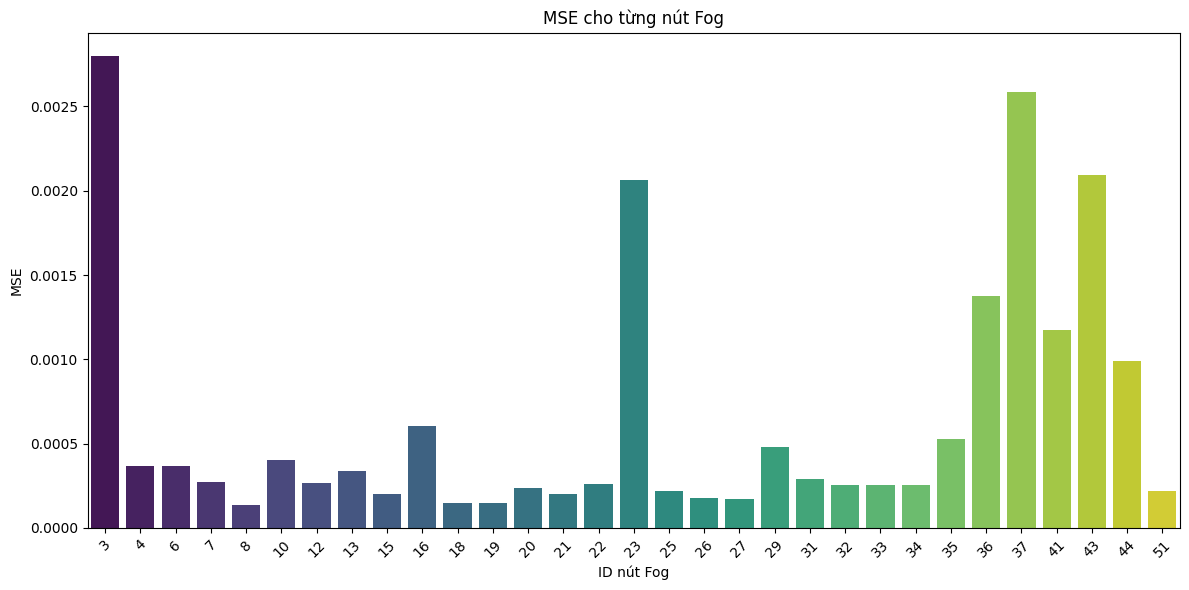

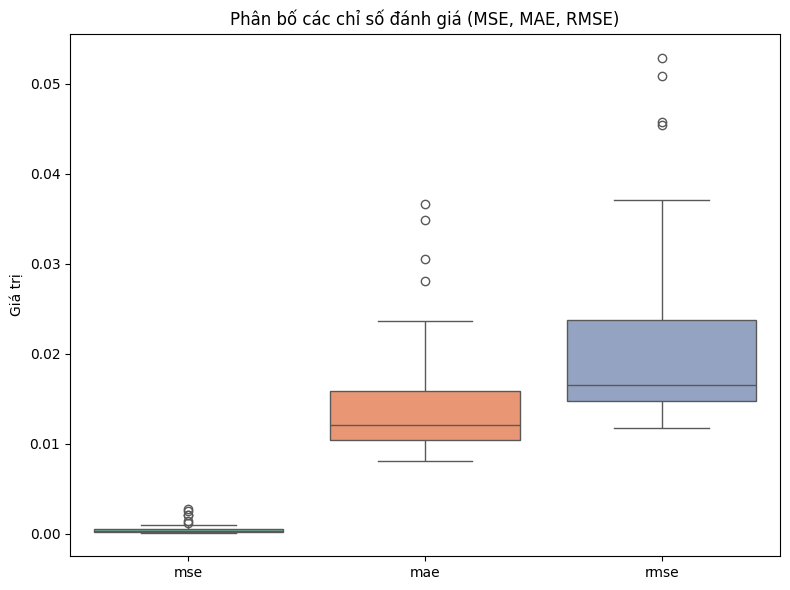

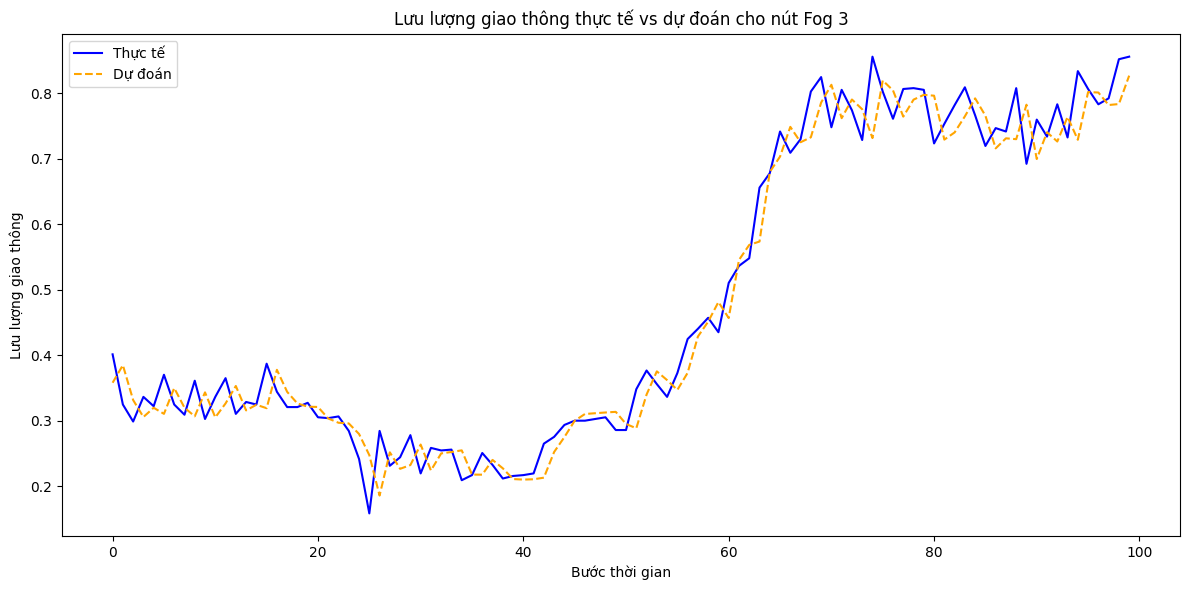

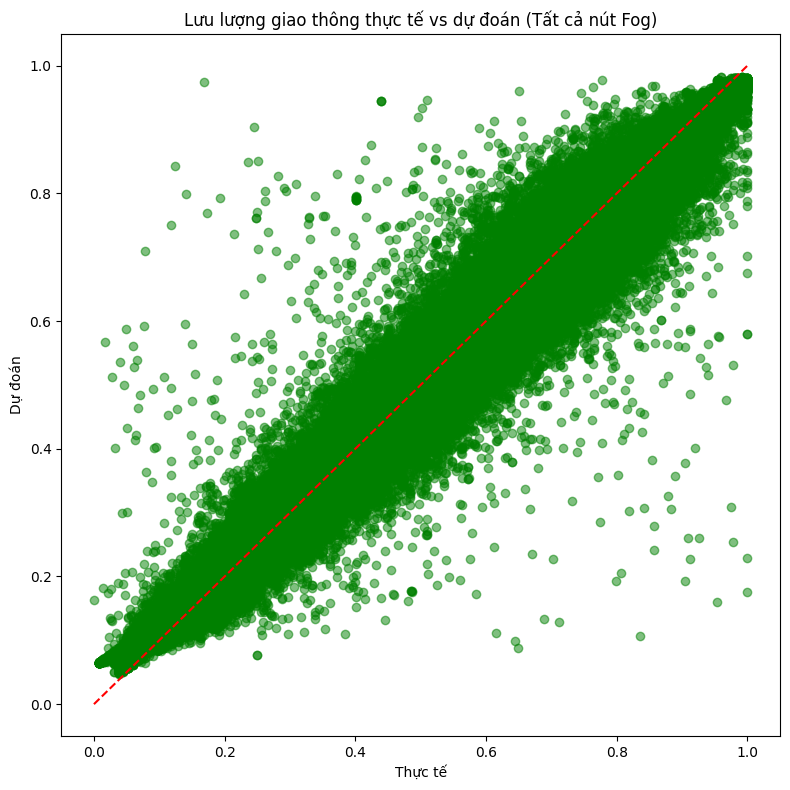

Các biểu đồ đã được hiển thị trên màn hình.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files  # Dùng cho Google Colab

# 1. Nhập file từ máy tính (Google Colab)
print("Vui lòng tải file evaluation_metrics.csv")
uploaded = files.upload()
eval_file = list(uploaded.keys())[0]
eval_df = pd.read_csv(eval_file)

print("Vui lòng tải file predictions.csv")
uploaded = files.upload()
pred_file = list(uploaded.keys())[0]
pred_df = pd.read_csv(pred_file)

# Nếu chạy trên máy cục bộ, bạn có thể thay bằng:
# eval_df = pd.read_csv('path/to/evaluation_metrics.csv')
# pred_df = pd.read_csv('path/to/predictions.csv')

# 2. Biểu đồ cột cho MSE của từng nút fog
plt.figure(figsize=(12, 6))
sns.barplot(x='fog_id', y='mse', data=eval_df, palette='viridis')
plt.title('MSE cho từng nút Fog')
plt.xlabel('ID nút Fog')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Biểu đồ hộp cho phân bố các chỉ số đánh giá
plt.figure(figsize=(8, 6))
sns.boxplot(data=eval_df[['mse', 'mae', 'rmse']], palette='Set2')
plt.title('Phân bố các chỉ số đánh giá (MSE, MAE, RMSE)')
plt.ylabel('Giá trị')
plt.tight_layout()
plt.show()

# 4. Biểu đồ đường cho giá trị thực tế và dự đoán của nút fog_id = 3
fog_id_to_plot = 3
fog_data = pred_df[pred_df['fog_id'] == fog_id_to_plot].reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.plot(fog_data.index[:100], fog_data['actual'][:100], label='Thực tế', color='blue')
plt.plot(fog_data.index[:100], fog_data['predicted'][:100], label='Dự đoán', color='orange', linestyle='--')
plt.title(f'Lưu lượng giao thông thực tế vs dự đoán cho nút Fog {fog_id_to_plot}')
plt.xlabel('Bước thời gian')
plt.ylabel('Lưu lượng giao thông')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Biểu đồ phân tán cho tất cả các nút fog
plt.figure(figsize=(8, 8))
plt.scatter(pred_df['actual'], pred_df['predicted'], alpha=0.5, color='green')
plt.plot([0, 1], [0, 1], 'r--')  # Đường tham chiếu y=x
plt.title('Lưu lượng giao thông thực tế vs dự đoán (Tất cả nút Fog)')
plt.xlabel('Thực tế')
plt.ylabel('Dự đoán')
plt.tight_layout()
plt.show()

print("Các biểu đồ đã được hiển thị trên màn hình.")